# Detecting Hidden LLM Model Drift with MMD²

*A statistical approach to catching silent API changes before they break your production systems*

---

**TL;DR:** LLM providers silently update models behind stable API endpoints. This can break your production systems without warning. Maximum Mean Discrepancy (MMD²) provides a mathematically rigorous way to detect these hidden changes using only model outputs—no internal access required.

## The Problem: Silent Model Drift

You've built a production system on top of `gemini-2.5-pro` or `gemini-3-flash-preview`. Your evaluations pass. Your prompts are tuned. Everything works.

Then one day, your system starts behaving differently. Outputs are longer. The tone has shifted. Edge cases that worked before now fail. But you didn't change anything.

**What happened?** The model behind the API endpoint was silently updated.

### Why This Matters

- **Production breakage**: Carefully tuned prompts may no longer work as expected
- **Invalid evaluations**: Benchmark results from last month may not reflect current behavior
- **Cost surprises**: Verbose outputs increase token costs
- **Compliance risks**: Behavioral changes may violate regulatory requirements

### The Challenge

You can't see inside the model. You only have access to its outputs. How do you detect that something has changed?

The answer: **compare output distributions statistically**.

## The Solution: MMD² (Maximum Mean Discrepancy)

MMD² is a statistical test that answers the question:

> *"Do these two sets of samples come from the same distribution?"*

For LLM drift detection, this becomes:

> *"Are today's model outputs statistically distinguishable from last week's outputs?"*

If yes → the model has drifted. If no → the model appears stable.

## The Math Behind MMD²

### Core Idea

Compare two distributions $P$ and $Q$ by mapping their samples to a high-dimensional feature space and measuring the distance between their means.

### The Formula

$$\text{MMD}^2(P, Q) = \mathbb{E}[k(x, x')] + \mathbb{E}[k(y, y')] - 2\mathbb{E}[k(x, y)]$$

Where:
- $x, x' \sim P$ (samples from distribution P)
- $y, y' \sim Q$ (samples from distribution Q)
- $k(\cdot, \cdot)$ is a kernel function

### Intuition

Think of it as measuring three things:
1. **How similar are samples within P to each other?** → $\mathbb{E}[k(x, x')]$
2. **How similar are samples within Q to each other?** → $\mathbb{E}[k(y, y')]$
3. **How similar are samples across P and Q?** → $\mathbb{E}[k(x, y)]$

If $P = Q$, all three terms should be equal, making MMD² = 0.

If $P \neq Q$, the cross-term will be smaller (less similar), making MMD² > 0.

## Why Kernels? The High-Dimensional Challenge

LLM outputs, when embedded, live in **384-1024 dimensional space**. Direct comparison in such high dimensions fails due to the curse of dimensionality—distances become meaningless as everything appears equally far apart.

### The Kernel Trick

Kernels implicitly map data to an even higher (potentially infinite) dimensional space called a **Reproducing Kernel Hilbert Space (RKHS)** where comparison becomes tractable.

### RBF Kernel (Radial Basis Function)

$$k(x, y) = \exp\left(-\gamma \|x - y\|^2\right)$$

- Returns 1 when $x = y$ (identical)
- Approaches 0 as $x$ and $y$ diverge
- $\gamma$ controls sensitivity to distance

The RBF kernel is a **universal approximator**—it can detect any difference between distributions given enough samples.

## Beyond Text: Multimodal Drift Detection

MMD² works with **any embedding space**. The same math applies to:

| Modality | Embedding Model | Use Case |
|----------|-----------------|----------|
| Text | sentence-transformers, E5 | LLM output drift |
| Images | CLIP, DINOv2 | Image generation drift |
| Audio | wav2vec, Whisper | Speech synthesis drift |
| Code | CodeBERT, StarCoder | Code generation drift |

If you can embed it, you can detect drift in it.

## Why MMD² Beats the Alternatives

| Method | Weakness | MMD² Advantage |
|--------|----------|----------------|
| **KL Divergence** | Requires density estimation; fails catastrophically in high dimensions | Works directly on samples |
| **Rule-based checks** | Brittle; misses subtle drift; requires constant maintenance | Captures any distribution-wide shift |
| **LLM-as-judge** | Expensive; adds noise; subjective; itself subject to drift | Deterministic, cheap, objective |
| **Cosine similarity** | Single-point comparison; misses distributional changes | Captures full distribution shape |
| **Output length checks** | Only catches one symptom | Catches style, tone, verbosity, accuracy shifts |

### Key Properties of MMD²

- **Noise-stable**: Permutation testing provides statistical rigor
- **High-dimensional native**: Designed for exactly this setting
- **Captures variety**: Style drift, verbosity changes, tone shifts
- **Low false alarms**: Null hypothesis testing prevents over-detection
- **Computationally efficient**: O(n²) for n samples—fast enough for real-time monitoring

## Experiment Setup

Let's implement MMD² drift detection and test it on real LLM outputs from Gemini models.

We collected responses from three different Gemini models:
- **gemini-3-flash-preview**: Latest preview model (fast, capable)
- **gemini-2.5-pro**: Current flagship model (slower, more capable)
- **gemini-2.0-flash-lite**: Lightweight model (fastest, most concise)

Each model was queried with 25 insurance policy Q&A prompts, with 10 samples per prompt, giving us **250 outputs per model** (750 total).

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sentence_transformers import SentenceTransformer

# Set random seed for reproducibility
np.random.seed(42)

# Use a readable style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/Users/abatutin/Documents/projects/verifier_primacy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Sample Prompts & Responses

We use **canary prompts**—structured questions with policy context that require consistent reasoning. These act as probes to detect behavioral changes.

Good canary prompts are:
- **Structured**: Clear expected reasoning pattern
- **Diverse**: Cover different response types (calculations, coverage decisions, policy lookups)
- **Deterministic**: Answers based on provided context, not world knowledge

Below are a few example prompts with sample responses from each model, showing how different models respond differently to the same question.

In [2]:
# Sample prompts and responses for illustration
# (These show the type of data we're working with)

SAMPLE_PROMPT_1 = """Query: How much will I pay out of pocket if my roof damage costs $8,500?
Context: Policy Section 4.2 - Deductibles
Your dwelling coverage deductible is $1,500 per occurrence. For wind/hail damage, 
a separate deductible of 2% of Coverage A limit applies. Your Coverage A limit is $250,000. 
The higher of the two deductibles applies to wind/hail claims."""

# Gemini 3 Flash Preview response (verbose, structured with markdown)
SAMPLE_RESPONSE_G3_FLASH = """
Based on the policy details provided, your out-of-pocket cost depends on the cause of the roof damage.

### 1. If the damage is caused by Wind or Hail:
*   **Standard Deductible:** $1,500
*   **Wind/Hail Deductible:** $5,000 (2% of your $250,000 Coverage A limit)
*   **Rule:** The policy states the **higher** of the two applies.
*   **Your Out-of-Pocket:** **$5,000**

### 2. If the damage is caused by any other covered peril:
*   **Standard Deductible:** $1,500
*   **Your Out-of-Pocket:** **$1,500**

**Summary:** If the roof damage is due to a storm (wind/hail), you will pay **$5,000** out of pocket.
"""

# Gemini 2.5 Pro response (balanced, clear structure)
SAMPLE_RESPONSE_G25_PRO = """
Based on the policy information provided, your out-of-pocket cost depends on the cause of the damage.

First, let's calculate the two possible deductibles:
1.  **Standard Deductible:** $1,500
2.  **Wind/Hail Deductible:** 2% of your $250,000 Coverage A limit, which is **$5,000**.

*   **If your roof damage is from wind or hail:** You will pay the higher deductible: **$5,000**.
*   **If your roof damage is from another covered event:** You will pay: **$1,500**.
"""

# Gemini 2.0 Flash Lite response (concise, calculation-focused)
SAMPLE_RESPONSE_G20_LITE = """
Here's how to calculate your out-of-pocket cost:

1.  **Wind/Hail Deductible:** 2% of $250,000 = $5,000
2.  **Compare Deductibles:** $5,000 > $1,500, so $5,000 applies.
3.  **Out-of-Pocket:** $8,500 - $5,000 = $3,500

**Answer:** You will pay $3,500 out of pocket.
"""

print("SAMPLE PROMPT:")
print("-" * 60)
print(SAMPLE_PROMPT_1[:200] + "...")
print()
print("RESPONSE COMPARISON:")
print("=" * 60)
print(f"Gemini 3 Flash Preview: {len(SAMPLE_RESPONSE_G3_FLASH)} chars")
print(f"Gemini 2.5 Pro:         {len(SAMPLE_RESPONSE_G25_PRO)} chars") 
print(f"Gemini 2.0 Flash Lite:  {len(SAMPLE_RESPONSE_G20_LITE)} chars")
print()
print("Note: Different models have distinctly different verbosity and formatting styles.")

SAMPLE PROMPT:
------------------------------------------------------------
Query: How much will I pay out of pocket if my roof damage costs $8,500?
Context: Policy Section 4.2 - Deductibles
Your dwelling coverage deductible is $1,500 per occurrence. For wind/hail damage, 
a ...

RESPONSE COMPARISON:
Gemini 3 Flash Preview: 609 chars
Gemini 2.5 Pro:         466 chars
Gemini 2.0 Flash Lite:  266 chars

Note: Different models have distinctly different verbosity and formatting styles.


### Loading the Full Dataset

For statistically meaningful results, we need many samples. We collected **250 outputs per model** (25 prompts × 10 samples each). Let's load them from our experiment files.

In [3]:
# Load experiment data from JSON files
DATA_DIR = Path("../data/mmd_test/experiment_outputs")

# File paths for each model's experiment output
FILES = {
    "gemini-3-flash-preview": DATA_DIR / "gemini_3_flash_preview_20260129_152753.json",
    "gemini-2.5-pro": DATA_DIR / "gemini_2.5_pro_20260129_152832.json",
    "gemini-2.0-flash-lite": DATA_DIR / "gemini_2.0_flash_lite_20260129_165332.json",
}

def load_outputs(filepath):
    """Load all outputs from an experiment JSON file."""
    with open(filepath) as f:
        data = json.load(f)
    outputs = [r["output"] for r in data["results"]]
    return outputs, data["metadata"]

# Load all datasets
datasets = {}
for model_name, filepath in FILES.items():
    outputs, metadata = load_outputs(filepath)
    datasets[model_name] = {
        "outputs": outputs,
        "metadata": metadata
    }
    print(f"Loaded {model_name}:")
    print(f"  - {len(outputs)} outputs ({metadata['n_prompts']} prompts × {metadata['n_samples']} samples)")
    print(f"  - Avg length: {np.mean([len(o) for o in outputs]):.0f} chars")
    print()

Loaded gemini-3-flash-preview:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 1230 chars

Loaded gemini-2.5-pro:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 1060 chars

Loaded gemini-2.0-flash-lite:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 1225 chars



### Embedding the Responses

We use `intfloat/e5-large-v2`, a high-quality 1024-dimensional text embedding model. The higher dimensionality captures more nuanced semantic differences than smaller models.

With 750 total outputs, embedding takes about 30-60 seconds depending on your hardware.

In [4]:
# Load embedding model
# Using e5-large-v2 for high-quality 1024-dim embeddings
# Fall back to MiniLM if e5 is not available
try:
    embedder = SentenceTransformer('intfloat/e5-large-v2')
    model_name = 'e5-large-v2'
    embed_dim = 1024
except:
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    model_name = 'MiniLM-L6-v2'
    embed_dim = 384

print(f"Using embedding model: {model_name} ({embed_dim} dimensions)")
print()

# Embed all outputs for each model
embeddings = {}
for model_name, data in datasets.items():
    print(f"Embedding {model_name}...")
    emb = embedder.encode(data["outputs"], show_progress_bar=True)
    embeddings[model_name] = emb
    print(f"  Shape: {emb.shape}")
    print()

# For convenience, create short aliases
emb_g3_flash = embeddings["gemini-3-flash-preview"]
emb_g25_pro = embeddings["gemini-2.5-pro"]
emb_g20_lite = embeddings["gemini-2.0-flash-lite"]

print(f"Total embeddings: {sum(e.shape[0] for e in embeddings.values())} vectors")

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Loading weights:   0%|          | 1/391 [00:00<00:00, 6853.44it/s, Materializing param=embeddings.LayerNorm.bias]

Loading weights:   0%|          | 1/391 [00:00<00:00, 470.64it/s, Materializing param=embeddings.LayerNorm.bias] 

Loading weights:   1%|          | 2/391 [00:00<00:00, 542.14it/s, Materializing param=embeddings.LayerNorm.weight]

Loading weights:   1%|          | 2/391 [00:00<00:00, 490.91it/s, Materializing param=embeddings.LayerNorm.weight]

Loading weights:   1%|          | 3/391 [00:00<00:00, 527.90it/s, Materializing param=embeddings.position_embeddings.weight]

Loading weights:   1%|          | 3/391 [00:00<00:00, 454.55it/s, Materializing param=embeddings.position_embeddings.weight]

Loading weights:   1%|          | 4/391 [00:00<00:00, 520.90it/s, Materializing param=embeddings.token_type_embeddings.weight]

Loading weights:   1%|          | 4/391 [00:00<00:00, 493.40it/s, Materializing param=embeddings.token_type_embeddings.weight]

Loading weights:   1%|▏         | 5/391 [00:00<00:00, 564.78it/s, Materializing param=embeddings.word_embeddings.weight]      

Loading weights:   1%|▏         | 5/391 [00:00<00:00, 493.97it/s, Materializing param=embeddings.word_embeddings.weight]

Loading weights:   2%|▏         | 6/391 [00:00<00:00, 542.20it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   2%|▏         | 6/391 [00:00<00:00, 527.07it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   2%|▏         | 7/391 [00:00<00:00, 570.04it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   2%|▏         | 7/391 [00:00<00:00, 530.06it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   2%|▏         | 8/391 [00:00<00:00, 571.84it/s, Materializing param=encoder.layer.0.attention.output.dense.bias]      

Loading weights:   2%|▏         | 8/391 [00:00<00:00, 561.65it/s, Materializing param=encoder.layer.0.attention.output.dense.bias]

Loading weights:   2%|▏         | 9/391 [00:00<00:00, 607.13it/s, Materializing param=encoder.layer.0.attention.output.dense.weight]

Loading weights:   2%|▏         | 9/391 [00:00<00:00, 564.55it/s, Materializing param=encoder.layer.0.attention.output.dense.weight]

Loading weights:   3%|▎         | 10/391 [00:00<00:00, 576.50it/s, Materializing param=encoder.layer.0.attention.self.key.bias]     

Loading weights:   3%|▎         | 10/391 [00:00<00:00, 544.81it/s, Materializing param=encoder.layer.0.attention.self.key.bias]

Loading weights:   3%|▎         | 11/391 [00:00<00:00, 584.71it/s, Materializing param=encoder.layer.0.attention.self.key.weight]

Loading weights:   3%|▎         | 11/391 [00:00<00:00, 567.66it/s, Materializing param=encoder.layer.0.attention.self.key.weight]

Loading weights:   3%|▎         | 12/391 [00:00<00:00, 554.07it/s, Materializing param=encoder.layer.0.attention.self.query.bias]

Loading weights:   3%|▎         | 12/391 [00:00<00:00, 545.02it/s, Materializing param=encoder.layer.0.attention.self.query.bias]

Loading weights:   3%|▎         | 13/391 [00:00<00:00, 576.93it/s, Materializing param=encoder.layer.0.attention.self.query.weight]

Loading weights:   3%|▎         | 13/391 [00:00<00:00, 564.48it/s, Materializing param=encoder.layer.0.attention.self.query.weight]

Loading weights:   4%|▎         | 14/391 [00:00<00:00, 588.51it/s, Materializing param=encoder.layer.0.attention.self.value.bias]  

Loading weights:   4%|▎         | 14/391 [00:00<00:00, 573.21it/s, Materializing param=encoder.layer.0.attention.self.value.bias]

Loading weights:   4%|▍         | 15/391 [00:00<00:00, 592.39it/s, Materializing param=encoder.layer.0.attention.self.value.weight]

Loading weights:   4%|▍         | 15/391 [00:00<00:00, 575.36it/s, Materializing param=encoder.layer.0.attention.self.value.weight]

Loading weights:   4%|▍         | 16/391 [00:00<00:00, 585.31it/s, Materializing param=encoder.layer.0.intermediate.dense.bias]    

Loading weights:   4%|▍         | 16/391 [00:00<00:00, 582.14it/s, Materializing param=encoder.layer.0.intermediate.dense.bias]

Loading weights:   4%|▍         | 17/391 [00:00<00:00, 593.70it/s, Materializing param=encoder.layer.0.intermediate.dense.weight]

Loading weights:   4%|▍         | 17/391 [00:00<00:00, 589.71it/s, Materializing param=encoder.layer.0.intermediate.dense.weight]

Loading weights:   5%|▍         | 18/391 [00:00<00:00, 605.68it/s, Materializing param=encoder.layer.0.output.LayerNorm.bias]    

Loading weights:   5%|▍         | 18/391 [00:00<00:00, 590.23it/s, Materializing param=encoder.layer.0.output.LayerNorm.bias]

Loading weights:   5%|▍         | 19/391 [00:00<00:00, 611.25it/s, Materializing param=encoder.layer.0.output.LayerNorm.weight]

Loading weights:   5%|▍         | 19/391 [00:00<00:00, 590.61it/s, Materializing param=encoder.layer.0.output.LayerNorm.weight]

Loading weights:   5%|▌         | 20/391 [00:00<00:00, 604.76it/s, Materializing param=encoder.layer.0.output.dense.bias]      

Loading weights:   5%|▌         | 20/391 [00:00<00:00, 593.69it/s, Materializing param=encoder.layer.0.output.dense.bias]

Loading weights:   5%|▌         | 21/391 [00:00<00:00, 613.28it/s, Materializing param=encoder.layer.0.output.dense.weight]

Loading weights:   5%|▌         | 21/391 [00:00<00:00, 609.30it/s, Materializing param=encoder.layer.0.output.dense.weight]

Loading weights:   6%|▌         | 22/391 [00:00<00:00, 623.12it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:   6%|▌         | 22/391 [00:00<00:00, 607.35it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:   6%|▌         | 23/391 [00:00<00:00, 625.56it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:   6%|▌         | 23/391 [00:00<00:00, 616.64it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:   6%|▌         | 24/391 [00:00<00:00, 633.21it/s, Materializing param=encoder.layer.1.attention.output.dense.bias]      

Loading weights:   6%|▌         | 24/391 [00:00<00:00, 628.96it/s, Materializing param=encoder.layer.1.attention.output.dense.bias]

Loading weights:   6%|▋         | 25/391 [00:00<00:00, 632.35it/s, Materializing param=encoder.layer.1.attention.output.dense.weight]

Loading weights:   6%|▋         | 25/391 [00:00<00:00, 622.73it/s, Materializing param=encoder.layer.1.attention.output.dense.weight]

Loading weights:   7%|▋         | 26/391 [00:00<00:00, 635.33it/s, Materializing param=encoder.layer.1.attention.self.key.bias]      

Loading weights:   7%|▋         | 26/391 [00:00<00:00, 623.37it/s, Materializing param=encoder.layer.1.attention.self.key.bias]

Loading weights:   7%|▋         | 27/391 [00:00<00:00, 639.49it/s, Materializing param=encoder.layer.1.attention.self.key.weight]

Loading weights:   7%|▋         | 27/391 [00:00<00:00, 614.25it/s, Materializing param=encoder.layer.1.attention.self.key.weight]

Loading weights:   7%|▋         | 28/391 [00:00<00:00, 621.97it/s, Materializing param=encoder.layer.1.attention.self.query.bias]

Loading weights:   7%|▋         | 28/391 [00:00<00:00, 613.69it/s, Materializing param=encoder.layer.1.attention.self.query.bias]

Loading weights:   7%|▋         | 29/391 [00:00<00:00, 625.26it/s, Materializing param=encoder.layer.1.attention.self.query.weight]

Loading weights:   7%|▋         | 29/391 [00:00<00:00, 613.12it/s, Materializing param=encoder.layer.1.attention.self.query.weight]

Loading weights:   8%|▊         | 30/391 [00:00<00:00, 613.91it/s, Materializing param=encoder.layer.1.attention.self.value.bias]  

Loading weights:   8%|▊         | 30/391 [00:00<00:00, 604.56it/s, Materializing param=encoder.layer.1.attention.self.value.bias]

Loading weights:   8%|▊         | 31/391 [00:00<00:00, 606.60it/s, Materializing param=encoder.layer.1.attention.self.value.weight]

Loading weights:   8%|▊         | 31/391 [00:00<00:00, 603.40it/s, Materializing param=encoder.layer.1.attention.self.value.weight]

Loading weights:   8%|▊         | 32/391 [00:00<00:00, 621.15it/s, Materializing param=encoder.layer.1.intermediate.dense.bias]    

Loading weights:   8%|▊         | 32/391 [00:00<00:00, 619.53it/s, Materializing param=encoder.layer.1.intermediate.dense.bias]

Loading weights:   8%|▊         | 33/391 [00:00<00:00, 637.10it/s, Materializing param=encoder.layer.1.intermediate.dense.weight]

Loading weights:   8%|▊         | 33/391 [00:00<00:00, 635.67it/s, Materializing param=encoder.layer.1.intermediate.dense.weight]

Loading weights:   9%|▊         | 34/391 [00:00<00:00, 653.27it/s, Materializing param=encoder.layer.1.output.LayerNorm.bias]    

Loading weights:   9%|▊         | 34/391 [00:00<00:00, 651.45it/s, Materializing param=encoder.layer.1.output.LayerNorm.bias]

Loading weights:   9%|▉         | 35/391 [00:00<00:00, 668.67it/s, Materializing param=encoder.layer.1.output.LayerNorm.weight]

Loading weights:   9%|▉         | 35/391 [00:00<00:00, 667.24it/s, Materializing param=encoder.layer.1.output.LayerNorm.weight]

Loading weights:   9%|▉         | 36/391 [00:00<00:00, 684.31it/s, Materializing param=encoder.layer.1.output.dense.bias]      

Loading weights:   9%|▉         | 36/391 [00:00<00:00, 682.77it/s, Materializing param=encoder.layer.1.output.dense.bias]

Loading weights:   9%|▉         | 37/391 [00:00<00:00, 699.55it/s, Materializing param=encoder.layer.1.output.dense.weight]

Loading weights:   9%|▉         | 37/391 [00:00<00:00, 697.69it/s, Materializing param=encoder.layer.1.output.dense.weight]

Loading weights:  10%|▉         | 38/391 [00:00<00:00, 714.57it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  10%|▉         | 38/391 [00:00<00:00, 713.20it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  10%|▉         | 39/391 [00:00<00:00, 730.05it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  10%|▉         | 39/391 [00:00<00:00, 728.50it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  10%|█         | 40/391 [00:00<00:00, 744.73it/s, Materializing param=encoder.layer.2.attention.output.dense.bias]      

Loading weights:  10%|█         | 40/391 [00:00<00:00, 743.00it/s, Materializing param=encoder.layer.2.attention.output.dense.bias]

Loading weights:  10%|█         | 41/391 [00:00<00:00, 759.77it/s, Materializing param=encoder.layer.2.attention.output.dense.weight]

Loading weights:  10%|█         | 41/391 [00:00<00:00, 758.22it/s, Materializing param=encoder.layer.2.attention.output.dense.weight]

Loading weights:  11%|█         | 42/391 [00:00<00:00, 774.60it/s, Materializing param=encoder.layer.2.attention.self.key.bias]      

Loading weights:  11%|█         | 42/391 [00:00<00:00, 772.25it/s, Materializing param=encoder.layer.2.attention.self.key.bias]

Loading weights:  11%|█         | 43/391 [00:00<00:00, 788.54it/s, Materializing param=encoder.layer.2.attention.self.key.weight]

Loading weights:  11%|█         | 43/391 [00:00<00:00, 786.81it/s, Materializing param=encoder.layer.2.attention.self.key.weight]

Loading weights:  11%|█▏        | 44/391 [00:00<00:00, 803.14it/s, Materializing param=encoder.layer.2.attention.self.query.bias]

Loading weights:  11%|█▏        | 44/391 [00:00<00:00, 801.47it/s, Materializing param=encoder.layer.2.attention.self.query.bias]

Loading weights:  12%|█▏        | 45/391 [00:00<00:00, 817.65it/s, Materializing param=encoder.layer.2.attention.self.query.weight]

Loading weights:  12%|█▏        | 45/391 [00:00<00:00, 816.03it/s, Materializing param=encoder.layer.2.attention.self.query.weight]

Loading weights:  12%|█▏        | 46/391 [00:00<00:00, 832.23it/s, Materializing param=encoder.layer.2.attention.self.value.bias]  

Loading weights:  12%|█▏        | 46/391 [00:00<00:00, 830.57it/s, Materializing param=encoder.layer.2.attention.self.value.bias]

Loading weights:  12%|█▏        | 47/391 [00:00<00:00, 846.53it/s, Materializing param=encoder.layer.2.attention.self.value.weight]

Loading weights:  12%|█▏        | 47/391 [00:00<00:00, 844.96it/s, Materializing param=encoder.layer.2.attention.self.value.weight]

Loading weights:  12%|█▏        | 48/391 [00:00<00:00, 861.05it/s, Materializing param=encoder.layer.2.intermediate.dense.bias]    

Loading weights:  12%|█▏        | 48/391 [00:00<00:00, 858.88it/s, Materializing param=encoder.layer.2.intermediate.dense.bias]

Loading weights:  13%|█▎        | 49/391 [00:00<00:00, 874.74it/s, Materializing param=encoder.layer.2.intermediate.dense.weight]

Loading weights:  13%|█▎        | 49/391 [00:00<00:00, 873.35it/s, Materializing param=encoder.layer.2.intermediate.dense.weight]

Loading weights:  13%|█▎        | 50/391 [00:00<00:00, 889.14it/s, Materializing param=encoder.layer.2.output.LayerNorm.bias]    

Loading weights:  13%|█▎        | 50/391 [00:00<00:00, 886.78it/s, Materializing param=encoder.layer.2.output.LayerNorm.bias]

Loading weights:  13%|█▎        | 51/391 [00:00<00:00, 902.13it/s, Materializing param=encoder.layer.2.output.LayerNorm.weight]

Loading weights:  13%|█▎        | 51/391 [00:00<00:00, 899.33it/s, Materializing param=encoder.layer.2.output.LayerNorm.weight]

Loading weights:  13%|█▎        | 52/391 [00:00<00:00, 915.00it/s, Materializing param=encoder.layer.2.output.dense.bias]      

Loading weights:  13%|█▎        | 52/391 [00:00<00:00, 913.10it/s, Materializing param=encoder.layer.2.output.dense.bias]

Loading weights:  14%|█▎        | 53/391 [00:00<00:00, 927.00it/s, Materializing param=encoder.layer.2.output.dense.weight]

Loading weights:  14%|█▎        | 53/391 [00:00<00:00, 924.42it/s, Materializing param=encoder.layer.2.output.dense.weight]

Loading weights:  14%|█▍        | 54/391 [00:00<00:00, 938.38it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  14%|█▍        | 54/391 [00:00<00:00, 936.65it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  14%|█▍        | 55/391 [00:00<00:00, 951.59it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  14%|█▍        | 55/391 [00:00<00:00, 949.87it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  14%|█▍        | 56/391 [00:00<00:00, 964.39it/s, Materializing param=encoder.layer.3.attention.output.dense.bias]      

Loading weights:  14%|█▍        | 56/391 [00:00<00:00, 962.30it/s, Materializing param=encoder.layer.3.attention.output.dense.bias]

Loading weights:  15%|█▍        | 57/391 [00:00<00:00, 977.37it/s, Materializing param=encoder.layer.3.attention.output.dense.weight]

Loading weights:  15%|█▍        | 57/391 [00:00<00:00, 975.41it/s, Materializing param=encoder.layer.3.attention.output.dense.weight]

Loading weights:  15%|█▍        | 58/391 [00:00<00:00, 989.87it/s, Materializing param=encoder.layer.3.attention.self.key.bias]      

Loading weights:  15%|█▍        | 58/391 [00:00<00:00, 987.89it/s, Materializing param=encoder.layer.3.attention.self.key.bias]

Loading weights:  15%|█▌        | 59/391 [00:00<00:00, 1002.65it/s, Materializing param=encoder.layer.3.attention.self.key.weight]

Loading weights:  15%|█▌        | 59/391 [00:00<00:00, 1000.05it/s, Materializing param=encoder.layer.3.attention.self.key.weight]

Loading weights:  15%|█▌        | 60/391 [00:00<00:00, 1014.64it/s, Materializing param=encoder.layer.3.attention.self.query.bias]

Loading weights:  15%|█▌        | 60/391 [00:00<00:00, 1012.85it/s, Materializing param=encoder.layer.3.attention.self.query.bias]

Loading weights:  16%|█▌        | 61/391 [00:00<00:00, 1025.81it/s, Materializing param=encoder.layer.3.attention.self.query.weight]

Loading weights:  16%|█▌        | 61/391 [00:00<00:00, 1023.82it/s, Materializing param=encoder.layer.3.attention.self.query.weight]

Loading weights:  16%|█▌        | 62/391 [00:00<00:00, 1035.53it/s, Materializing param=encoder.layer.3.attention.self.value.bias]  

Loading weights:  16%|█▌        | 62/391 [00:00<00:00, 1033.52it/s, Materializing param=encoder.layer.3.attention.self.value.bias]

Loading weights:  16%|█▌        | 63/391 [00:00<00:00, 1046.86it/s, Materializing param=encoder.layer.3.attention.self.value.weight]

Loading weights:  16%|█▌        | 63/391 [00:00<00:00, 1044.38it/s, Materializing param=encoder.layer.3.attention.self.value.weight]

Loading weights:  16%|█▋        | 64/391 [00:00<00:00, 1056.88it/s, Materializing param=encoder.layer.3.intermediate.dense.bias]    

Loading weights:  16%|█▋        | 64/391 [00:00<00:00, 1053.72it/s, Materializing param=encoder.layer.3.intermediate.dense.bias]

Loading weights:  17%|█▋        | 65/391 [00:00<00:00, 1067.36it/s, Materializing param=encoder.layer.3.intermediate.dense.weight]

Loading weights:  17%|█▋        | 65/391 [00:00<00:00, 1065.16it/s, Materializing param=encoder.layer.3.intermediate.dense.weight]

Loading weights:  17%|█▋        | 66/391 [00:00<00:00, 1078.80it/s, Materializing param=encoder.layer.3.output.LayerNorm.bias]    

Loading weights:  17%|█▋        | 66/391 [00:00<00:00, 1076.76it/s, Materializing param=encoder.layer.3.output.LayerNorm.bias]

Loading weights:  17%|█▋        | 67/391 [00:00<00:00, 1090.91it/s, Materializing param=encoder.layer.3.output.LayerNorm.weight]

Loading weights:  17%|█▋        | 67/391 [00:00<00:00, 1089.18it/s, Materializing param=encoder.layer.3.output.LayerNorm.weight]

Loading weights:  17%|█▋        | 68/391 [00:00<00:00, 1101.98it/s, Materializing param=encoder.layer.3.output.dense.bias]      

Loading weights:  17%|█▋        | 68/391 [00:00<00:00, 1100.01it/s, Materializing param=encoder.layer.3.output.dense.bias]

Loading weights:  18%|█▊        | 69/391 [00:00<00:00, 1113.82it/s, Materializing param=encoder.layer.3.output.dense.weight]

Loading weights:  18%|█▊        | 69/391 [00:00<00:00, 1111.85it/s, Materializing param=encoder.layer.3.output.dense.weight]

Loading weights:  18%|█▊        | 70/391 [00:00<00:00, 1125.59it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  18%|█▊        | 70/391 [00:00<00:00, 1123.52it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  18%|█▊        | 71/391 [00:00<00:00, 1136.31it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  18%|█▊        | 71/391 [00:00<00:00, 1133.17it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  18%|█▊        | 72/391 [00:00<00:00, 1146.94it/s, Materializing param=encoder.layer.4.attention.output.dense.bias]      

Loading weights:  18%|█▊        | 72/391 [00:00<00:00, 1144.82it/s, Materializing param=encoder.layer.4.attention.output.dense.bias]

Loading weights:  19%|█▊        | 73/391 [00:00<00:00, 1157.52it/s, Materializing param=encoder.layer.4.attention.output.dense.weight]

Loading weights:  19%|█▊        | 73/391 [00:00<00:00, 1155.62it/s, Materializing param=encoder.layer.4.attention.output.dense.weight]

Loading weights:  19%|█▉        | 74/391 [00:00<00:00, 1168.88it/s, Materializing param=encoder.layer.4.attention.self.key.bias]      

Loading weights:  19%|█▉        | 74/391 [00:00<00:00, 1166.86it/s, Materializing param=encoder.layer.4.attention.self.key.bias]

Loading weights:  19%|█▉        | 75/391 [00:00<00:00, 1179.10it/s, Materializing param=encoder.layer.4.attention.self.key.weight]

Loading weights:  19%|█▉        | 75/391 [00:00<00:00, 1176.64it/s, Materializing param=encoder.layer.4.attention.self.key.weight]

Loading weights:  19%|█▉        | 76/391 [00:00<00:00, 1190.03it/s, Materializing param=encoder.layer.4.attention.self.query.bias]

Loading weights:  19%|█▉        | 76/391 [00:00<00:00, 1187.89it/s, Materializing param=encoder.layer.4.attention.self.query.bias]

Loading weights:  20%|█▉        | 77/391 [00:00<00:00, 1201.12it/s, Materializing param=encoder.layer.4.attention.self.query.weight]

Loading weights:  20%|█▉        | 77/391 [00:00<00:00, 1198.52it/s, Materializing param=encoder.layer.4.attention.self.query.weight]

Loading weights:  20%|█▉        | 78/391 [00:00<00:00, 1210.02it/s, Materializing param=encoder.layer.4.attention.self.value.bias]  

Loading weights:  20%|█▉        | 78/391 [00:00<00:00, 1207.96it/s, Materializing param=encoder.layer.4.attention.self.value.bias]

Loading weights:  20%|██        | 79/391 [00:00<00:00, 1220.55it/s, Materializing param=encoder.layer.4.attention.self.value.weight]

Loading weights:  20%|██        | 79/391 [00:00<00:00, 1218.20it/s, Materializing param=encoder.layer.4.attention.self.value.weight]

Loading weights:  20%|██        | 80/391 [00:00<00:00, 1230.89it/s, Materializing param=encoder.layer.4.intermediate.dense.bias]    

Loading weights:  20%|██        | 80/391 [00:00<00:00, 1228.47it/s, Materializing param=encoder.layer.4.intermediate.dense.bias]

Loading weights:  21%|██        | 81/391 [00:00<00:00, 1241.44it/s, Materializing param=encoder.layer.4.intermediate.dense.weight]

Loading weights:  21%|██        | 81/391 [00:00<00:00, 1239.48it/s, Materializing param=encoder.layer.4.intermediate.dense.weight]

Loading weights:  21%|██        | 82/391 [00:00<00:00, 1252.23it/s, Materializing param=encoder.layer.4.output.LayerNorm.bias]    

Loading weights:  21%|██        | 82/391 [00:00<00:00, 1250.02it/s, Materializing param=encoder.layer.4.output.LayerNorm.bias]

Loading weights:  21%|██        | 83/391 [00:00<00:00, 1262.67it/s, Materializing param=encoder.layer.4.output.LayerNorm.weight]

Loading weights:  21%|██        | 83/391 [00:00<00:00, 1260.40it/s, Materializing param=encoder.layer.4.output.LayerNorm.weight]

Loading weights:  21%|██▏       | 84/391 [00:00<00:00, 1272.73it/s, Materializing param=encoder.layer.4.output.dense.bias]      

Loading weights:  21%|██▏       | 84/391 [00:00<00:00, 1270.32it/s, Materializing param=encoder.layer.4.output.dense.bias]

Loading weights:  22%|██▏       | 85/391 [00:00<00:00, 1281.03it/s, Materializing param=encoder.layer.4.output.dense.weight]

Loading weights:  22%|██▏       | 85/391 [00:00<00:00, 1278.60it/s, Materializing param=encoder.layer.4.output.dense.weight]

Loading weights:  22%|██▏       | 86/391 [00:00<00:00, 1289.20it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  22%|██▏       | 86/391 [00:00<00:00, 1286.25it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  22%|██▏       | 87/391 [00:00<00:00, 1298.04it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  22%|██▏       | 87/391 [00:00<00:00, 1295.45it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  23%|██▎       | 88/391 [00:00<00:00, 1307.44it/s, Materializing param=encoder.layer.5.attention.output.dense.bias]      

Loading weights:  23%|██▎       | 88/391 [00:00<00:00, 1305.38it/s, Materializing param=encoder.layer.5.attention.output.dense.bias]

Loading weights:  23%|██▎       | 89/391 [00:00<00:00, 1317.23it/s, Materializing param=encoder.layer.5.attention.output.dense.weight]

Loading weights:  23%|██▎       | 89/391 [00:00<00:00, 1315.07it/s, Materializing param=encoder.layer.5.attention.output.dense.weight]

Loading weights:  23%|██▎       | 90/391 [00:00<00:00, 1327.03it/s, Materializing param=encoder.layer.5.attention.self.key.bias]      

Loading weights:  23%|██▎       | 90/391 [00:00<00:00, 1324.68it/s, Materializing param=encoder.layer.5.attention.self.key.bias]

Loading weights:  23%|██▎       | 91/391 [00:00<00:00, 1336.17it/s, Materializing param=encoder.layer.5.attention.self.key.weight]

Loading weights:  23%|██▎       | 91/391 [00:00<00:00, 1333.59it/s, Materializing param=encoder.layer.5.attention.self.key.weight]

Loading weights:  24%|██▎       | 92/391 [00:00<00:00, 1345.50it/s, Materializing param=encoder.layer.5.attention.self.query.bias]

Loading weights:  24%|██▎       | 92/391 [00:00<00:00, 1343.09it/s, Materializing param=encoder.layer.5.attention.self.query.bias]

Loading weights:  24%|██▍       | 93/391 [00:00<00:00, 1354.74it/s, Materializing param=encoder.layer.5.attention.self.query.weight]

Loading weights:  24%|██▍       | 93/391 [00:00<00:00, 1352.69it/s, Materializing param=encoder.layer.5.attention.self.query.weight]

Loading weights:  24%|██▍       | 94/391 [00:00<00:00, 1364.70it/s, Materializing param=encoder.layer.5.attention.self.value.bias]  

Loading weights:  24%|██▍       | 94/391 [00:00<00:00, 1362.22it/s, Materializing param=encoder.layer.5.attention.self.value.bias]

Loading weights:  24%|██▍       | 95/391 [00:00<00:00, 1374.06it/s, Materializing param=encoder.layer.5.attention.self.value.weight]

Loading weights:  24%|██▍       | 95/391 [00:00<00:00, 1371.76it/s, Materializing param=encoder.layer.5.attention.self.value.weight]

Loading weights:  25%|██▍       | 96/391 [00:00<00:00, 1383.41it/s, Materializing param=encoder.layer.5.intermediate.dense.bias]    

Loading weights:  25%|██▍       | 96/391 [00:00<00:00, 1381.23it/s, Materializing param=encoder.layer.5.intermediate.dense.bias]

Loading weights:  25%|██▍       | 97/391 [00:00<00:00, 1391.74it/s, Materializing param=encoder.layer.5.intermediate.dense.weight]

Loading weights:  25%|██▍       | 97/391 [00:00<00:00, 1388.95it/s, Materializing param=encoder.layer.5.intermediate.dense.weight]

Loading weights:  25%|██▌       | 98/391 [00:00<00:00, 1400.10it/s, Materializing param=encoder.layer.5.output.LayerNorm.bias]    

Loading weights:  25%|██▌       | 98/391 [00:00<00:00, 1397.71it/s, Materializing param=encoder.layer.5.output.LayerNorm.bias]

Loading weights:  25%|██▌       | 99/391 [00:00<00:00, 1409.25it/s, Materializing param=encoder.layer.5.output.LayerNorm.weight]

Loading weights:  25%|██▌       | 99/391 [00:00<00:00, 1406.75it/s, Materializing param=encoder.layer.5.output.LayerNorm.weight]

Loading weights:  26%|██▌       | 100/391 [00:00<00:00, 1417.94it/s, Materializing param=encoder.layer.5.output.dense.bias]     

Loading weights:  26%|██▌       | 100/391 [00:00<00:00, 1415.57it/s, Materializing param=encoder.layer.5.output.dense.bias]

Loading weights:  26%|██▌       | 101/391 [00:00<00:00, 1426.84it/s, Materializing param=encoder.layer.5.output.dense.weight]

Loading weights:  26%|██▌       | 101/391 [00:00<00:00, 1424.34it/s, Materializing param=encoder.layer.5.output.dense.weight]

Loading weights:  26%|██▌       | 102/391 [00:00<00:00, 1435.39it/s, Materializing param=encoder.layer.6.attention.output.LayerNorm.bias]

Loading weights:  26%|██▌       | 102/391 [00:00<00:00, 1432.91it/s, Materializing param=encoder.layer.6.attention.output.LayerNorm.bias]

Loading weights:  26%|██▋       | 103/391 [00:00<00:00, 1443.51it/s, Materializing param=encoder.layer.6.attention.output.LayerNorm.weight]

Loading weights:  26%|██▋       | 103/391 [00:00<00:00, 1440.82it/s, Materializing param=encoder.layer.6.attention.output.LayerNorm.weight]

Loading weights:  27%|██▋       | 104/391 [00:00<00:00, 1451.91it/s, Materializing param=encoder.layer.6.attention.output.dense.bias]      

Loading weights:  27%|██▋       | 104/391 [00:00<00:00, 1449.38it/s, Materializing param=encoder.layer.6.attention.output.dense.bias]

Loading weights:  27%|██▋       | 105/391 [00:00<00:00, 1460.45it/s, Materializing param=encoder.layer.6.attention.output.dense.weight]

Loading weights:  27%|██▋       | 105/391 [00:00<00:00, 1457.48it/s, Materializing param=encoder.layer.6.attention.output.dense.weight]

Loading weights:  27%|██▋       | 106/391 [00:00<00:00, 1467.66it/s, Materializing param=encoder.layer.6.attention.self.key.bias]      

Loading weights:  27%|██▋       | 106/391 [00:00<00:00, 1465.06it/s, Materializing param=encoder.layer.6.attention.self.key.bias]

Loading weights:  27%|██▋       | 107/391 [00:00<00:00, 1475.78it/s, Materializing param=encoder.layer.6.attention.self.key.weight]

Loading weights:  27%|██▋       | 107/391 [00:00<00:00, 1472.33it/s, Materializing param=encoder.layer.6.attention.self.key.weight]

Loading weights:  28%|██▊       | 108/391 [00:00<00:00, 1482.89it/s, Materializing param=encoder.layer.6.attention.self.query.bias]

Loading weights:  28%|██▊       | 108/391 [00:00<00:00, 1479.55it/s, Materializing param=encoder.layer.6.attention.self.query.bias]

Loading weights:  28%|██▊       | 109/391 [00:00<00:00, 1489.99it/s, Materializing param=encoder.layer.6.attention.self.query.weight]

Loading weights:  28%|██▊       | 109/391 [00:00<00:00, 1487.08it/s, Materializing param=encoder.layer.6.attention.self.query.weight]

Loading weights:  28%|██▊       | 110/391 [00:00<00:00, 1497.64it/s, Materializing param=encoder.layer.6.attention.self.value.bias]  

Loading weights:  28%|██▊       | 110/391 [00:00<00:00, 1495.14it/s, Materializing param=encoder.layer.6.attention.self.value.bias]

Loading weights:  28%|██▊       | 111/391 [00:00<00:00, 1505.76it/s, Materializing param=encoder.layer.6.attention.self.value.weight]

Loading weights:  28%|██▊       | 111/391 [00:00<00:00, 1503.25it/s, Materializing param=encoder.layer.6.attention.self.value.weight]

Loading weights:  29%|██▊       | 112/391 [00:00<00:00, 1513.93it/s, Materializing param=encoder.layer.6.intermediate.dense.bias]    

Loading weights:  29%|██▊       | 112/391 [00:00<00:00, 1511.62it/s, Materializing param=encoder.layer.6.intermediate.dense.bias]

Loading weights:  29%|██▉       | 113/391 [00:00<00:00, 1522.03it/s, Materializing param=encoder.layer.6.intermediate.dense.weight]

Loading weights:  29%|██▉       | 113/391 [00:00<00:00, 1519.14it/s, Materializing param=encoder.layer.6.intermediate.dense.weight]

Loading weights:  29%|██▉       | 114/391 [00:00<00:00, 1529.73it/s, Materializing param=encoder.layer.6.output.LayerNorm.bias]    

Loading weights:  29%|██▉       | 114/391 [00:00<00:00, 1527.34it/s, Materializing param=encoder.layer.6.output.LayerNorm.bias]

Loading weights:  29%|██▉       | 115/391 [00:00<00:00, 1537.75it/s, Materializing param=encoder.layer.6.output.LayerNorm.weight]

Loading weights:  29%|██▉       | 115/391 [00:00<00:00, 1534.13it/s, Materializing param=encoder.layer.6.output.LayerNorm.weight]

Loading weights:  30%|██▉       | 116/391 [00:00<00:00, 1544.11it/s, Materializing param=encoder.layer.6.output.dense.bias]      

Loading weights:  30%|██▉       | 116/391 [00:00<00:00, 1541.66it/s, Materializing param=encoder.layer.6.output.dense.bias]

Loading weights:  30%|██▉       | 117/391 [00:00<00:00, 1551.89it/s, Materializing param=encoder.layer.6.output.dense.weight]

Loading weights:  30%|██▉       | 117/391 [00:00<00:00, 1549.38it/s, Materializing param=encoder.layer.6.output.dense.weight]

Loading weights:  30%|███       | 118/391 [00:00<00:00, 1559.01it/s, Materializing param=encoder.layer.7.attention.output.LayerNorm.bias]

Loading weights:  30%|███       | 118/391 [00:00<00:00, 1554.68it/s, Materializing param=encoder.layer.7.attention.output.LayerNorm.bias]

Loading weights:  30%|███       | 119/391 [00:00<00:00, 1563.12it/s, Materializing param=encoder.layer.7.attention.output.LayerNorm.weight]

Loading weights:  30%|███       | 119/391 [00:00<00:00, 1560.08it/s, Materializing param=encoder.layer.7.attention.output.LayerNorm.weight]

Loading weights:  31%|███       | 120/391 [00:00<00:00, 1569.57it/s, Materializing param=encoder.layer.7.attention.output.dense.bias]      

Loading weights:  31%|███       | 120/391 [00:00<00:00, 1566.99it/s, Materializing param=encoder.layer.7.attention.output.dense.bias]

Loading weights:  31%|███       | 121/391 [00:00<00:00, 1575.15it/s, Materializing param=encoder.layer.7.attention.output.dense.weight]

Loading weights:  31%|███       | 121/391 [00:00<00:00, 1573.00it/s, Materializing param=encoder.layer.7.attention.output.dense.weight]

Loading weights:  31%|███       | 122/391 [00:00<00:00, 1583.19it/s, Materializing param=encoder.layer.7.attention.self.key.bias]      

Loading weights:  31%|███       | 122/391 [00:00<00:00, 1580.58it/s, Materializing param=encoder.layer.7.attention.self.key.bias]

Loading weights:  31%|███▏      | 123/391 [00:00<00:00, 1590.51it/s, Materializing param=encoder.layer.7.attention.self.key.weight]

Loading weights:  31%|███▏      | 123/391 [00:00<00:00, 1587.39it/s, Materializing param=encoder.layer.7.attention.self.key.weight]

Loading weights:  32%|███▏      | 124/391 [00:00<00:00, 1597.11it/s, Materializing param=encoder.layer.7.attention.self.query.bias]

Loading weights:  32%|███▏      | 124/391 [00:00<00:00, 1594.24it/s, Materializing param=encoder.layer.7.attention.self.query.bias]

Loading weights:  32%|███▏      | 125/391 [00:00<00:00, 1603.45it/s, Materializing param=encoder.layer.7.attention.self.query.weight]

Loading weights:  32%|███▏      | 125/391 [00:00<00:00, 1600.80it/s, Materializing param=encoder.layer.7.attention.self.query.weight]

Loading weights:  32%|███▏      | 126/391 [00:00<00:00, 1610.35it/s, Materializing param=encoder.layer.7.attention.self.value.bias]  

Loading weights:  32%|███▏      | 126/391 [00:00<00:00, 1607.95it/s, Materializing param=encoder.layer.7.attention.self.value.bias]

Loading weights:  32%|███▏      | 127/391 [00:00<00:00, 1617.69it/s, Materializing param=encoder.layer.7.attention.self.value.weight]

Loading weights:  32%|███▏      | 127/391 [00:00<00:00, 1615.00it/s, Materializing param=encoder.layer.7.attention.self.value.weight]

Loading weights:  33%|███▎      | 128/391 [00:00<00:00, 1623.60it/s, Materializing param=encoder.layer.7.intermediate.dense.bias]    

Loading weights:  33%|███▎      | 128/391 [00:00<00:00, 1619.86it/s, Materializing param=encoder.layer.7.intermediate.dense.bias]

Loading weights:  33%|███▎      | 129/391 [00:00<00:00, 1629.64it/s, Materializing param=encoder.layer.7.intermediate.dense.weight]

Loading weights:  33%|███▎      | 129/391 [00:00<00:00, 1627.17it/s, Materializing param=encoder.layer.7.intermediate.dense.weight]

Loading weights:  33%|███▎      | 130/391 [00:00<00:00, 1636.75it/s, Materializing param=encoder.layer.7.output.LayerNorm.bias]    

Loading weights:  33%|███▎      | 130/391 [00:00<00:00, 1634.32it/s, Materializing param=encoder.layer.7.output.LayerNorm.bias]

Loading weights:  34%|███▎      | 131/391 [00:00<00:00, 1643.87it/s, Materializing param=encoder.layer.7.output.LayerNorm.weight]

Loading weights:  34%|███▎      | 131/391 [00:00<00:00, 1641.42it/s, Materializing param=encoder.layer.7.output.LayerNorm.weight]

Loading weights:  34%|███▍      | 132/391 [00:00<00:00, 1650.83it/s, Materializing param=encoder.layer.7.output.dense.bias]      

Loading weights:  34%|███▍      | 132/391 [00:00<00:00, 1648.17it/s, Materializing param=encoder.layer.7.output.dense.bias]

Loading weights:  34%|███▍      | 133/391 [00:00<00:00, 1657.71it/s, Materializing param=encoder.layer.7.output.dense.weight]

Loading weights:  34%|███▍      | 133/391 [00:00<00:00, 1655.12it/s, Materializing param=encoder.layer.7.output.dense.weight]

Loading weights:  34%|███▍      | 134/391 [00:00<00:00, 1664.06it/s, Materializing param=encoder.layer.8.attention.output.LayerNorm.bias]

Loading weights:  34%|███▍      | 134/391 [00:00<00:00, 1661.63it/s, Materializing param=encoder.layer.8.attention.output.LayerNorm.bias]

Loading weights:  35%|███▍      | 135/391 [00:00<00:00, 1671.15it/s, Materializing param=encoder.layer.8.attention.output.LayerNorm.weight]

Loading weights:  35%|███▍      | 135/391 [00:00<00:00, 1668.69it/s, Materializing param=encoder.layer.8.attention.output.LayerNorm.weight]

Loading weights:  35%|███▍      | 136/391 [00:00<00:00, 1678.19it/s, Materializing param=encoder.layer.8.attention.output.dense.bias]      

Loading weights:  35%|███▍      | 136/391 [00:00<00:00, 1675.66it/s, Materializing param=encoder.layer.8.attention.output.dense.bias]

Loading weights:  35%|███▌      | 137/391 [00:00<00:00, 1685.02it/s, Materializing param=encoder.layer.8.attention.output.dense.weight]

Loading weights:  35%|███▌      | 137/391 [00:00<00:00, 1682.55it/s, Materializing param=encoder.layer.8.attention.output.dense.weight]

Loading weights:  35%|███▌      | 138/391 [00:00<00:00, 1691.76it/s, Materializing param=encoder.layer.8.attention.self.key.bias]      

Loading weights:  35%|███▌      | 138/391 [00:00<00:00, 1689.30it/s, Materializing param=encoder.layer.8.attention.self.key.bias]

Loading weights:  36%|███▌      | 139/391 [00:00<00:00, 1697.23it/s, Materializing param=encoder.layer.8.attention.self.key.weight]

Loading weights:  36%|███▌      | 139/391 [00:00<00:00, 1694.79it/s, Materializing param=encoder.layer.8.attention.self.key.weight]

Loading weights:  36%|███▌      | 140/391 [00:00<00:00, 1703.64it/s, Materializing param=encoder.layer.8.attention.self.query.bias]

Loading weights:  36%|███▌      | 140/391 [00:00<00:00, 1701.20it/s, Materializing param=encoder.layer.8.attention.self.query.bias]

Loading weights:  36%|███▌      | 141/391 [00:00<00:00, 1710.52it/s, Materializing param=encoder.layer.8.attention.self.query.weight]

Loading weights:  36%|███▌      | 141/391 [00:00<00:00, 1708.10it/s, Materializing param=encoder.layer.8.attention.self.query.weight]

Loading weights:  36%|███▋      | 142/391 [00:00<00:00, 1717.34it/s, Materializing param=encoder.layer.8.attention.self.value.bias]  

Loading weights:  36%|███▋      | 142/391 [00:00<00:00, 1714.85it/s, Materializing param=encoder.layer.8.attention.self.value.bias]

Loading weights:  37%|███▋      | 143/391 [00:00<00:00, 1723.93it/s, Materializing param=encoder.layer.8.attention.self.value.weight]

Loading weights:  37%|███▋      | 143/391 [00:00<00:00, 1721.55it/s, Materializing param=encoder.layer.8.attention.self.value.weight]

Loading weights:  37%|███▋      | 144/391 [00:00<00:00, 1731.06it/s, Materializing param=encoder.layer.8.intermediate.dense.bias]    

Loading weights:  37%|███▋      | 144/391 [00:00<00:00, 1728.59it/s, Materializing param=encoder.layer.8.intermediate.dense.bias]

Loading weights:  37%|███▋      | 145/391 [00:00<00:00, 1736.99it/s, Materializing param=encoder.layer.8.intermediate.dense.weight]

Loading weights:  37%|███▋      | 145/391 [00:00<00:00, 1733.89it/s, Materializing param=encoder.layer.8.intermediate.dense.weight]

Loading weights:  37%|███▋      | 146/391 [00:00<00:00, 1743.10it/s, Materializing param=encoder.layer.8.output.LayerNorm.bias]    

Loading weights:  37%|███▋      | 146/391 [00:00<00:00, 1740.75it/s, Materializing param=encoder.layer.8.output.LayerNorm.bias]

Loading weights:  38%|███▊      | 147/391 [00:00<00:00, 1749.67it/s, Materializing param=encoder.layer.8.output.LayerNorm.weight]

Loading weights:  38%|███▊      | 147/391 [00:00<00:00, 1747.17it/s, Materializing param=encoder.layer.8.output.LayerNorm.weight]

Loading weights:  38%|███▊      | 148/391 [00:00<00:00, 1755.99it/s, Materializing param=encoder.layer.8.output.dense.bias]      

Loading weights:  38%|███▊      | 148/391 [00:00<00:00, 1753.41it/s, Materializing param=encoder.layer.8.output.dense.bias]

Loading weights:  38%|███▊      | 149/391 [00:00<00:00, 1762.50it/s, Materializing param=encoder.layer.8.output.dense.weight]

Loading weights:  38%|███▊      | 149/391 [00:00<00:00, 1760.40it/s, Materializing param=encoder.layer.8.output.dense.weight]

Loading weights:  38%|███▊      | 150/391 [00:00<00:00, 1769.18it/s, Materializing param=encoder.layer.9.attention.output.LayerNorm.bias]

Loading weights:  38%|███▊      | 150/391 [00:00<00:00, 1765.06it/s, Materializing param=encoder.layer.9.attention.output.LayerNorm.bias]

Loading weights:  39%|███▊      | 151/391 [00:00<00:00, 1773.78it/s, Materializing param=encoder.layer.9.attention.output.LayerNorm.weight]

Loading weights:  39%|███▊      | 151/391 [00:00<00:00, 1770.85it/s, Materializing param=encoder.layer.9.attention.output.LayerNorm.weight]

Loading weights:  39%|███▉      | 152/391 [00:00<00:00, 1779.61it/s, Materializing param=encoder.layer.9.attention.output.dense.bias]      

Loading weights:  39%|███▉      | 152/391 [00:00<00:00, 1776.99it/s, Materializing param=encoder.layer.9.attention.output.dense.bias]

Loading weights:  39%|███▉      | 153/391 [00:00<00:00, 1785.63it/s, Materializing param=encoder.layer.9.attention.output.dense.weight]

Loading weights:  39%|███▉      | 153/391 [00:00<00:00, 1783.43it/s, Materializing param=encoder.layer.9.attention.output.dense.weight]

Loading weights:  39%|███▉      | 154/391 [00:00<00:00, 1792.26it/s, Materializing param=encoder.layer.9.attention.self.key.bias]      

Loading weights:  39%|███▉      | 154/391 [00:00<00:00, 1789.49it/s, Materializing param=encoder.layer.9.attention.self.key.bias]

Loading weights:  40%|███▉      | 155/391 [00:00<00:00, 1796.98it/s, Materializing param=encoder.layer.9.attention.self.key.weight]

Loading weights:  40%|███▉      | 155/391 [00:00<00:00, 1794.09it/s, Materializing param=encoder.layer.9.attention.self.key.weight]

Loading weights:  40%|███▉      | 156/391 [00:00<00:00, 1802.32it/s, Materializing param=encoder.layer.9.attention.self.query.bias]

Loading weights:  40%|███▉      | 156/391 [00:00<00:00, 1799.93it/s, Materializing param=encoder.layer.9.attention.self.query.bias]

Loading weights:  40%|████      | 157/391 [00:00<00:00, 1808.41it/s, Materializing param=encoder.layer.9.attention.self.query.weight]

Loading weights:  40%|████      | 157/391 [00:00<00:00, 1805.68it/s, Materializing param=encoder.layer.9.attention.self.query.weight]

Loading weights:  40%|████      | 158/391 [00:00<00:00, 1814.13it/s, Materializing param=encoder.layer.9.attention.self.value.bias]  

Loading weights:  40%|████      | 158/391 [00:00<00:00, 1811.32it/s, Materializing param=encoder.layer.9.attention.self.value.bias]

Loading weights:  41%|████      | 159/391 [00:00<00:00, 1819.89it/s, Materializing param=encoder.layer.9.attention.self.value.weight]

Loading weights:  41%|████      | 159/391 [00:00<00:00, 1817.43it/s, Materializing param=encoder.layer.9.attention.self.value.weight]

Loading weights:  41%|████      | 160/391 [00:00<00:00, 1825.75it/s, Materializing param=encoder.layer.9.intermediate.dense.bias]    

Loading weights:  41%|████      | 160/391 [00:00<00:00, 1821.62it/s, Materializing param=encoder.layer.9.intermediate.dense.bias]

Loading weights:  41%|████      | 161/391 [00:00<00:00, 1828.24it/s, Materializing param=encoder.layer.9.intermediate.dense.weight]

Loading weights:  41%|████      | 161/391 [00:00<00:00, 1824.76it/s, Materializing param=encoder.layer.9.intermediate.dense.weight]

Loading weights:  41%|████▏     | 162/391 [00:00<00:00, 1832.65it/s, Materializing param=encoder.layer.9.output.LayerNorm.bias]    

Loading weights:  41%|████▏     | 162/391 [00:00<00:00, 1829.93it/s, Materializing param=encoder.layer.9.output.LayerNorm.bias]

Loading weights:  42%|████▏     | 163/391 [00:00<00:00, 1838.00it/s, Materializing param=encoder.layer.9.output.LayerNorm.weight]

Loading weights:  42%|████▏     | 163/391 [00:00<00:00, 1835.32it/s, Materializing param=encoder.layer.9.output.LayerNorm.weight]

Loading weights:  42%|████▏     | 164/391 [00:00<00:00, 1843.36it/s, Materializing param=encoder.layer.9.output.dense.bias]      

Loading weights:  42%|████▏     | 164/391 [00:00<00:00, 1840.48it/s, Materializing param=encoder.layer.9.output.dense.bias]

Loading weights:  42%|████▏     | 165/391 [00:00<00:00, 1848.00it/s, Materializing param=encoder.layer.9.output.dense.weight]

Loading weights:  42%|████▏     | 165/391 [00:00<00:00, 1845.16it/s, Materializing param=encoder.layer.9.output.dense.weight]

Loading weights:  42%|████▏     | 166/391 [00:00<00:00, 1852.16it/s, Materializing param=encoder.layer.10.attention.output.LayerNorm.bias]

Loading weights:  42%|████▏     | 166/391 [00:00<00:00, 1849.39it/s, Materializing param=encoder.layer.10.attention.output.LayerNorm.bias]

Loading weights:  43%|████▎     | 167/391 [00:00<00:00, 1856.94it/s, Materializing param=encoder.layer.10.attention.output.LayerNorm.weight]

Loading weights:  43%|████▎     | 167/391 [00:00<00:00, 1854.38it/s, Materializing param=encoder.layer.10.attention.output.LayerNorm.weight]

Loading weights:  43%|████▎     | 168/391 [00:00<00:00, 1862.24it/s, Materializing param=encoder.layer.10.attention.output.dense.bias]      

Loading weights:  43%|████▎     | 168/391 [00:00<00:00, 1859.66it/s, Materializing param=encoder.layer.10.attention.output.dense.bias]

Loading weights:  43%|████▎     | 169/391 [00:00<00:00, 1867.82it/s, Materializing param=encoder.layer.10.attention.output.dense.weight]

Loading weights:  43%|████▎     | 169/391 [00:00<00:00, 1865.20it/s, Materializing param=encoder.layer.10.attention.output.dense.weight]

Loading weights:  43%|████▎     | 170/391 [00:00<00:00, 1873.30it/s, Materializing param=encoder.layer.10.attention.self.key.bias]      

Loading weights:  43%|████▎     | 170/391 [00:00<00:00, 1870.43it/s, Materializing param=encoder.layer.10.attention.self.key.bias]

Loading weights:  44%|████▎     | 171/391 [00:00<00:00, 1876.54it/s, Materializing param=encoder.layer.10.attention.self.key.weight]

Loading weights:  44%|████▎     | 171/391 [00:00<00:00, 1873.79it/s, Materializing param=encoder.layer.10.attention.self.key.weight]

Loading weights:  44%|████▍     | 172/391 [00:00<00:00, 1880.61it/s, Materializing param=encoder.layer.10.attention.self.query.bias]

Loading weights:  44%|████▍     | 172/391 [00:00<00:00, 1878.08it/s, Materializing param=encoder.layer.10.attention.self.query.bias]

Loading weights:  44%|████▍     | 173/391 [00:00<00:00, 1885.79it/s, Materializing param=encoder.layer.10.attention.self.query.weight]

Loading weights:  44%|████▍     | 173/391 [00:00<00:00, 1883.02it/s, Materializing param=encoder.layer.10.attention.self.query.weight]

Loading weights:  45%|████▍     | 174/391 [00:00<00:00, 1890.65it/s, Materializing param=encoder.layer.10.attention.self.value.bias]  

Loading weights:  45%|████▍     | 174/391 [00:00<00:00, 1886.26it/s, Materializing param=encoder.layer.10.attention.self.value.bias]

Loading weights:  45%|████▍     | 175/391 [00:00<00:00, 1893.94it/s, Materializing param=encoder.layer.10.attention.self.value.weight]

Loading weights:  45%|████▍     | 175/391 [00:00<00:00, 1891.44it/s, Materializing param=encoder.layer.10.attention.self.value.weight]

Loading weights:  45%|████▌     | 176/391 [00:00<00:00, 1899.03it/s, Materializing param=encoder.layer.10.intermediate.dense.bias]    

Loading weights:  45%|████▌     | 176/391 [00:00<00:00, 1896.12it/s, Materializing param=encoder.layer.10.intermediate.dense.bias]

Loading weights:  45%|████▌     | 177/391 [00:00<00:00, 1902.92it/s, Materializing param=encoder.layer.10.intermediate.dense.weight]

Loading weights:  45%|████▌     | 177/391 [00:00<00:00, 1900.04it/s, Materializing param=encoder.layer.10.intermediate.dense.weight]

Loading weights:  46%|████▌     | 178/391 [00:00<00:00, 1907.13it/s, Materializing param=encoder.layer.10.output.LayerNorm.bias]    

Loading weights:  46%|████▌     | 178/391 [00:00<00:00, 1904.52it/s, Materializing param=encoder.layer.10.output.LayerNorm.bias]

Loading weights:  46%|████▌     | 179/391 [00:00<00:00, 1911.55it/s, Materializing param=encoder.layer.10.output.LayerNorm.weight]

Loading weights:  46%|████▌     | 179/391 [00:00<00:00, 1908.85it/s, Materializing param=encoder.layer.10.output.LayerNorm.weight]

Loading weights:  46%|████▌     | 180/391 [00:00<00:00, 1916.18it/s, Materializing param=encoder.layer.10.output.dense.bias]      

Loading weights:  46%|████▌     | 180/391 [00:00<00:00, 1912.31it/s, Materializing param=encoder.layer.10.output.dense.bias]

Loading weights:  46%|████▋     | 181/391 [00:00<00:00, 1919.77it/s, Materializing param=encoder.layer.10.output.dense.weight]

Loading weights:  46%|████▋     | 181/391 [00:00<00:00, 1917.35it/s, Materializing param=encoder.layer.10.output.dense.weight]

Loading weights:  47%|████▋     | 182/391 [00:00<00:00, 1924.76it/s, Materializing param=encoder.layer.11.attention.output.LayerNorm.bias]

Loading weights:  47%|████▋     | 182/391 [00:00<00:00, 1922.00it/s, Materializing param=encoder.layer.11.attention.output.LayerNorm.bias]

Loading weights:  47%|████▋     | 183/391 [00:00<00:00, 1929.08it/s, Materializing param=encoder.layer.11.attention.output.LayerNorm.weight]

Loading weights:  47%|████▋     | 183/391 [00:00<00:00, 1926.56it/s, Materializing param=encoder.layer.11.attention.output.LayerNorm.weight]

Loading weights:  47%|████▋     | 184/391 [00:00<00:00, 1932.39it/s, Materializing param=encoder.layer.11.attention.output.dense.bias]      

Loading weights:  47%|████▋     | 184/391 [00:00<00:00, 1929.95it/s, Materializing param=encoder.layer.11.attention.output.dense.bias]

Loading weights:  47%|████▋     | 185/391 [00:00<00:00, 1937.58it/s, Materializing param=encoder.layer.11.attention.output.dense.weight]

Loading weights:  47%|████▋     | 185/391 [00:00<00:00, 1934.95it/s, Materializing param=encoder.layer.11.attention.output.dense.weight]

Loading weights:  48%|████▊     | 186/391 [00:00<00:00, 1942.25it/s, Materializing param=encoder.layer.11.attention.self.key.bias]      

Loading weights:  48%|████▊     | 186/391 [00:00<00:00, 1939.64it/s, Materializing param=encoder.layer.11.attention.self.key.bias]

Loading weights:  48%|████▊     | 187/391 [00:00<00:00, 1947.19it/s, Materializing param=encoder.layer.11.attention.self.key.weight]

Loading weights:  48%|████▊     | 187/391 [00:00<00:00, 1944.78it/s, Materializing param=encoder.layer.11.attention.self.key.weight]

Loading weights:  48%|████▊     | 188/391 [00:00<00:00, 1952.20it/s, Materializing param=encoder.layer.11.attention.self.query.bias]

Loading weights:  48%|████▊     | 188/391 [00:00<00:00, 1949.70it/s, Materializing param=encoder.layer.11.attention.self.query.bias]

Loading weights:  48%|████▊     | 189/391 [00:00<00:00, 1957.17it/s, Materializing param=encoder.layer.11.attention.self.query.weight]

Loading weights:  48%|████▊     | 189/391 [00:00<00:00, 1954.64it/s, Materializing param=encoder.layer.11.attention.self.query.weight]

Loading weights:  49%|████▊     | 190/391 [00:00<00:00, 1961.96it/s, Materializing param=encoder.layer.11.attention.self.value.bias]  

Loading weights:  49%|████▊     | 190/391 [00:00<00:00, 1959.59it/s, Materializing param=encoder.layer.11.attention.self.value.bias]

Loading weights:  49%|████▉     | 191/391 [00:00<00:00, 1964.62it/s, Materializing param=encoder.layer.11.attention.self.value.weight]

Loading weights:  49%|████▉     | 191/391 [00:00<00:00, 1962.44it/s, Materializing param=encoder.layer.11.attention.self.value.weight]

Loading weights:  49%|████▉     | 192/391 [00:00<00:00, 1969.94it/s, Materializing param=encoder.layer.11.intermediate.dense.bias]    

Loading weights:  49%|████▉     | 192/391 [00:00<00:00, 1967.07it/s, Materializing param=encoder.layer.11.intermediate.dense.bias]

Loading weights:  49%|████▉     | 193/391 [00:00<00:00, 1974.57it/s, Materializing param=encoder.layer.11.intermediate.dense.weight]

Loading weights:  49%|████▉     | 193/391 [00:00<00:00, 1972.33it/s, Materializing param=encoder.layer.11.intermediate.dense.weight]

Loading weights:  50%|████▉     | 194/391 [00:00<00:00, 1979.21it/s, Materializing param=encoder.layer.11.output.LayerNorm.bias]    

Loading weights:  50%|████▉     | 194/391 [00:00<00:00, 1976.85it/s, Materializing param=encoder.layer.11.output.LayerNorm.bias]

Loading weights:  50%|████▉     | 195/391 [00:00<00:00, 1984.08it/s, Materializing param=encoder.layer.11.output.LayerNorm.weight]

Loading weights:  50%|████▉     | 195/391 [00:00<00:00, 1981.79it/s, Materializing param=encoder.layer.11.output.LayerNorm.weight]

Loading weights:  50%|█████     | 196/391 [00:00<00:00, 1988.01it/s, Materializing param=encoder.layer.11.output.dense.bias]      

Loading weights:  50%|█████     | 196/391 [00:00<00:00, 1985.30it/s, Materializing param=encoder.layer.11.output.dense.bias]

Loading weights:  50%|█████     | 197/391 [00:00<00:00, 1992.15it/s, Materializing param=encoder.layer.11.output.dense.weight]

Loading weights:  50%|█████     | 197/391 [00:00<00:00, 1989.74it/s, Materializing param=encoder.layer.11.output.dense.weight]

Loading weights:  51%|█████     | 198/391 [00:00<00:00, 1997.00it/s, Materializing param=encoder.layer.12.attention.output.LayerNorm.bias]

Loading weights:  51%|█████     | 198/391 [00:00<00:00, 1994.63it/s, Materializing param=encoder.layer.12.attention.output.LayerNorm.bias]

Loading weights:  51%|█████     | 199/391 [00:00<00:00, 2001.75it/s, Materializing param=encoder.layer.12.attention.output.LayerNorm.weight]

Loading weights:  51%|█████     | 199/391 [00:00<00:00, 1999.04it/s, Materializing param=encoder.layer.12.attention.output.LayerNorm.weight]

Loading weights:  51%|█████     | 200/391 [00:00<00:00, 2006.10it/s, Materializing param=encoder.layer.12.attention.output.dense.bias]      

Loading weights:  51%|█████     | 200/391 [00:00<00:00, 2003.73it/s, Materializing param=encoder.layer.12.attention.output.dense.bias]

Loading weights:  51%|█████▏    | 201/391 [00:00<00:00, 2010.85it/s, Materializing param=encoder.layer.12.attention.output.dense.weight]

Loading weights:  51%|█████▏    | 201/391 [00:00<00:00, 2007.09it/s, Materializing param=encoder.layer.12.attention.output.dense.weight]

Loading weights:  52%|█████▏    | 202/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.output.dense.weight]

Loading weights:  52%|█████▏    | 202/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.key.bias]      

Loading weights:  52%|█████▏    | 202/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.key.bias]

Loading weights:  52%|█████▏    | 203/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.key.weight]

Loading weights:  52%|█████▏    | 203/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.key.weight]

Loading weights:  52%|█████▏    | 204/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.query.bias]

Loading weights:  52%|█████▏    | 204/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.query.bias]

Loading weights:  52%|█████▏    | 205/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.query.weight]

Loading weights:  52%|█████▏    | 205/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.query.weight]

Loading weights:  53%|█████▎    | 206/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.value.bias]  

Loading weights:  53%|█████▎    | 206/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.value.bias]

Loading weights:  53%|█████▎    | 207/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.value.weight]

Loading weights:  53%|█████▎    | 207/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.attention.self.value.weight]

Loading weights:  53%|█████▎    | 208/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.intermediate.dense.bias]    

Loading weights:  53%|█████▎    | 208/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.intermediate.dense.bias]

Loading weights:  53%|█████▎    | 209/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.intermediate.dense.weight]

Loading weights:  53%|█████▎    | 209/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.intermediate.dense.weight]

Loading weights:  54%|█████▎    | 210/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.output.LayerNorm.bias]    

Loading weights:  54%|█████▎    | 210/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.output.LayerNorm.bias]

Loading weights:  54%|█████▍    | 211/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.output.LayerNorm.weight]

Loading weights:  54%|█████▍    | 211/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.output.LayerNorm.weight]

Loading weights:  54%|█████▍    | 212/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.output.dense.bias]      

Loading weights:  54%|█████▍    | 212/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.output.dense.bias]

Loading weights:  54%|█████▍    | 213/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.output.dense.weight]

Loading weights:  54%|█████▍    | 213/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.12.output.dense.weight]

Loading weights:  55%|█████▍    | 214/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.output.LayerNorm.bias]

Loading weights:  55%|█████▍    | 214/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.output.LayerNorm.bias]

Loading weights:  55%|█████▍    | 215/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.output.LayerNorm.weight]

Loading weights:  55%|█████▍    | 215/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.output.LayerNorm.weight]

Loading weights:  55%|█████▌    | 216/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.output.dense.bias]      

Loading weights:  55%|█████▌    | 216/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.output.dense.bias]

Loading weights:  55%|█████▌    | 217/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.output.dense.weight]

Loading weights:  55%|█████▌    | 217/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.output.dense.weight]

Loading weights:  56%|█████▌    | 218/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.key.bias]      

Loading weights:  56%|█████▌    | 218/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.key.bias]

Loading weights:  56%|█████▌    | 219/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.key.weight]

Loading weights:  56%|█████▌    | 219/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.key.weight]

Loading weights:  56%|█████▋    | 220/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.query.bias]

Loading weights:  56%|█████▋    | 220/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.query.bias]

Loading weights:  57%|█████▋    | 221/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.query.weight]

Loading weights:  57%|█████▋    | 221/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.query.weight]

Loading weights:  57%|█████▋    | 222/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.value.bias]  

Loading weights:  57%|█████▋    | 222/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.value.bias]

Loading weights:  57%|█████▋    | 223/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.value.weight]

Loading weights:  57%|█████▋    | 223/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.attention.self.value.weight]

Loading weights:  57%|█████▋    | 224/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.intermediate.dense.bias]    

Loading weights:  57%|█████▋    | 224/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.intermediate.dense.bias]

Loading weights:  58%|█████▊    | 225/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.intermediate.dense.weight]

Loading weights:  58%|█████▊    | 225/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.intermediate.dense.weight]

Loading weights:  58%|█████▊    | 226/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.output.LayerNorm.bias]    

Loading weights:  58%|█████▊    | 226/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.output.LayerNorm.bias]

Loading weights:  58%|█████▊    | 227/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.output.LayerNorm.weight]

Loading weights:  58%|█████▊    | 227/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.output.LayerNorm.weight]

Loading weights:  58%|█████▊    | 228/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.output.dense.bias]      

Loading weights:  58%|█████▊    | 228/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.output.dense.bias]

Loading weights:  59%|█████▊    | 229/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.output.dense.weight]

Loading weights:  59%|█████▊    | 229/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.13.output.dense.weight]

Loading weights:  59%|█████▉    | 230/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.output.LayerNorm.bias]

Loading weights:  59%|█████▉    | 230/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.output.LayerNorm.bias]

Loading weights:  59%|█████▉    | 231/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.output.LayerNorm.weight]

Loading weights:  59%|█████▉    | 231/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.output.LayerNorm.weight]

Loading weights:  59%|█████▉    | 232/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.output.dense.bias]      

Loading weights:  59%|█████▉    | 232/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.output.dense.bias]

Loading weights:  60%|█████▉    | 233/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.output.dense.weight]

Loading weights:  60%|█████▉    | 233/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.output.dense.weight]

Loading weights:  60%|█████▉    | 234/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.key.bias]      

Loading weights:  60%|█████▉    | 234/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.key.bias]

Loading weights:  60%|██████    | 235/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.key.weight]

Loading weights:  60%|██████    | 235/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.key.weight]

Loading weights:  60%|██████    | 236/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.query.bias]

Loading weights:  60%|██████    | 236/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.query.bias]

Loading weights:  61%|██████    | 237/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.query.weight]

Loading weights:  61%|██████    | 237/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.query.weight]

Loading weights:  61%|██████    | 238/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.value.bias]  

Loading weights:  61%|██████    | 238/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.value.bias]

Loading weights:  61%|██████    | 239/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.value.weight]

Loading weights:  61%|██████    | 239/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.attention.self.value.weight]

Loading weights:  61%|██████▏   | 240/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.intermediate.dense.bias]    

Loading weights:  61%|██████▏   | 240/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.intermediate.dense.bias]

Loading weights:  62%|██████▏   | 241/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.intermediate.dense.weight]

Loading weights:  62%|██████▏   | 241/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.intermediate.dense.weight]

Loading weights:  62%|██████▏   | 242/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.output.LayerNorm.bias]    

Loading weights:  62%|██████▏   | 242/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.output.LayerNorm.bias]

Loading weights:  62%|██████▏   | 243/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.output.LayerNorm.weight]

Loading weights:  62%|██████▏   | 243/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.output.LayerNorm.weight]

Loading weights:  62%|██████▏   | 244/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.output.dense.bias]      

Loading weights:  62%|██████▏   | 244/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.output.dense.bias]

Loading weights:  63%|██████▎   | 245/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.output.dense.weight]

Loading weights:  63%|██████▎   | 245/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.14.output.dense.weight]

Loading weights:  63%|██████▎   | 246/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.output.LayerNorm.bias]

Loading weights:  63%|██████▎   | 246/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.output.LayerNorm.bias]

Loading weights:  63%|██████▎   | 247/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.output.LayerNorm.weight]

Loading weights:  63%|██████▎   | 247/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.output.LayerNorm.weight]

Loading weights:  63%|██████▎   | 248/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.output.dense.bias]      

Loading weights:  63%|██████▎   | 248/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.output.dense.bias]

Loading weights:  64%|██████▎   | 249/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.output.dense.weight]

Loading weights:  64%|██████▎   | 249/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.output.dense.weight]

Loading weights:  64%|██████▍   | 250/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.key.bias]      

Loading weights:  64%|██████▍   | 250/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.key.bias]

Loading weights:  64%|██████▍   | 251/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.key.weight]

Loading weights:  64%|██████▍   | 251/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.key.weight]

Loading weights:  64%|██████▍   | 252/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.query.bias]

Loading weights:  64%|██████▍   | 252/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.query.bias]

Loading weights:  65%|██████▍   | 253/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.query.weight]

Loading weights:  65%|██████▍   | 253/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.query.weight]

Loading weights:  65%|██████▍   | 254/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.value.bias]  

Loading weights:  65%|██████▍   | 254/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.value.bias]

Loading weights:  65%|██████▌   | 255/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.value.weight]

Loading weights:  65%|██████▌   | 255/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.attention.self.value.weight]

Loading weights:  65%|██████▌   | 256/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.intermediate.dense.bias]    

Loading weights:  65%|██████▌   | 256/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.intermediate.dense.bias]

Loading weights:  66%|██████▌   | 257/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.intermediate.dense.weight]

Loading weights:  66%|██████▌   | 257/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.intermediate.dense.weight]

Loading weights:  66%|██████▌   | 258/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.output.LayerNorm.bias]    

Loading weights:  66%|██████▌   | 258/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.output.LayerNorm.bias]

Loading weights:  66%|██████▌   | 259/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.output.LayerNorm.weight]

Loading weights:  66%|██████▌   | 259/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.output.LayerNorm.weight]

Loading weights:  66%|██████▋   | 260/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.output.dense.bias]      

Loading weights:  66%|██████▋   | 260/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.output.dense.bias]

Loading weights:  67%|██████▋   | 261/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.output.dense.weight]

Loading weights:  67%|██████▋   | 261/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.15.output.dense.weight]

Loading weights:  67%|██████▋   | 262/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.output.LayerNorm.bias]

Loading weights:  67%|██████▋   | 262/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.output.LayerNorm.bias]

Loading weights:  67%|██████▋   | 263/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.output.LayerNorm.weight]

Loading weights:  67%|██████▋   | 263/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.output.LayerNorm.weight]

Loading weights:  68%|██████▊   | 264/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.output.dense.bias]      

Loading weights:  68%|██████▊   | 264/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.output.dense.bias]

Loading weights:  68%|██████▊   | 265/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.output.dense.weight]

Loading weights:  68%|██████▊   | 265/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.output.dense.weight]

Loading weights:  68%|██████▊   | 266/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.key.bias]      

Loading weights:  68%|██████▊   | 266/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.key.bias]

Loading weights:  68%|██████▊   | 267/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.key.weight]

Loading weights:  68%|██████▊   | 267/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.key.weight]

Loading weights:  69%|██████▊   | 268/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.query.bias]

Loading weights:  69%|██████▊   | 268/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.query.bias]

Loading weights:  69%|██████▉   | 269/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.query.weight]

Loading weights:  69%|██████▉   | 269/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.query.weight]

Loading weights:  69%|██████▉   | 270/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.value.bias]  

Loading weights:  69%|██████▉   | 270/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.value.bias]

Loading weights:  69%|██████▉   | 271/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.value.weight]

Loading weights:  69%|██████▉   | 271/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.attention.self.value.weight]

Loading weights:  70%|██████▉   | 272/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.intermediate.dense.bias]    

Loading weights:  70%|██████▉   | 272/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.intermediate.dense.bias]

Loading weights:  70%|██████▉   | 273/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.intermediate.dense.weight]

Loading weights:  70%|██████▉   | 273/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.intermediate.dense.weight]

Loading weights:  70%|███████   | 274/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.output.LayerNorm.bias]    

Loading weights:  70%|███████   | 274/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.output.LayerNorm.bias]

Loading weights:  70%|███████   | 275/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.output.LayerNorm.weight]

Loading weights:  70%|███████   | 275/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.output.LayerNorm.weight]

Loading weights:  71%|███████   | 276/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.output.dense.bias]      

Loading weights:  71%|███████   | 276/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.output.dense.bias]

Loading weights:  71%|███████   | 277/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.output.dense.weight]

Loading weights:  71%|███████   | 277/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.16.output.dense.weight]

Loading weights:  71%|███████   | 278/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.output.LayerNorm.bias]

Loading weights:  71%|███████   | 278/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.output.LayerNorm.bias]

Loading weights:  71%|███████▏  | 279/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.output.LayerNorm.weight]

Loading weights:  71%|███████▏  | 279/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.output.LayerNorm.weight]

Loading weights:  72%|███████▏  | 280/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.output.dense.bias]      

Loading weights:  72%|███████▏  | 280/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.output.dense.bias]

Loading weights:  72%|███████▏  | 281/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.output.dense.weight]

Loading weights:  72%|███████▏  | 281/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.output.dense.weight]

Loading weights:  72%|███████▏  | 282/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.key.bias]      

Loading weights:  72%|███████▏  | 282/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.key.bias]

Loading weights:  72%|███████▏  | 283/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.key.weight]

Loading weights:  72%|███████▏  | 283/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.key.weight]

Loading weights:  73%|███████▎  | 284/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.query.bias]

Loading weights:  73%|███████▎  | 284/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.query.bias]

Loading weights:  73%|███████▎  | 285/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.query.weight]

Loading weights:  73%|███████▎  | 285/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.query.weight]

Loading weights:  73%|███████▎  | 286/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.value.bias]  

Loading weights:  73%|███████▎  | 286/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.value.bias]

Loading weights:  73%|███████▎  | 287/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.value.weight]

Loading weights:  73%|███████▎  | 287/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.attention.self.value.weight]

Loading weights:  74%|███████▎  | 288/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.intermediate.dense.bias]    

Loading weights:  74%|███████▎  | 288/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.intermediate.dense.bias]

Loading weights:  74%|███████▍  | 289/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.intermediate.dense.weight]

Loading weights:  74%|███████▍  | 289/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.intermediate.dense.weight]

Loading weights:  74%|███████▍  | 290/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.output.LayerNorm.bias]    

Loading weights:  74%|███████▍  | 290/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.output.LayerNorm.bias]

Loading weights:  74%|███████▍  | 291/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.output.LayerNorm.weight]

Loading weights:  74%|███████▍  | 291/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.output.LayerNorm.weight]

Loading weights:  75%|███████▍  | 292/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.output.dense.bias]      

Loading weights:  75%|███████▍  | 292/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.output.dense.bias]

Loading weights:  75%|███████▍  | 293/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.output.dense.weight]

Loading weights:  75%|███████▍  | 293/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.17.output.dense.weight]

Loading weights:  75%|███████▌  | 294/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.output.LayerNorm.bias]

Loading weights:  75%|███████▌  | 294/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.output.LayerNorm.bias]

Loading weights:  75%|███████▌  | 295/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.output.LayerNorm.weight]

Loading weights:  75%|███████▌  | 295/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.output.LayerNorm.weight]

Loading weights:  76%|███████▌  | 296/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.output.dense.bias]      

Loading weights:  76%|███████▌  | 296/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.output.dense.bias]

Loading weights:  76%|███████▌  | 297/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.output.dense.weight]

Loading weights:  76%|███████▌  | 297/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.output.dense.weight]

Loading weights:  76%|███████▌  | 298/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.key.bias]      

Loading weights:  76%|███████▌  | 298/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.key.bias]

Loading weights:  76%|███████▋  | 299/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.key.weight]

Loading weights:  76%|███████▋  | 299/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.key.weight]

Loading weights:  77%|███████▋  | 300/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.query.bias]

Loading weights:  77%|███████▋  | 300/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.query.bias]

Loading weights:  77%|███████▋  | 301/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.query.weight]

Loading weights:  77%|███████▋  | 301/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.query.weight]

Loading weights:  77%|███████▋  | 302/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.value.bias]  

Loading weights:  77%|███████▋  | 302/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.value.bias]

Loading weights:  77%|███████▋  | 303/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.value.weight]

Loading weights:  77%|███████▋  | 303/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.attention.self.value.weight]

Loading weights:  78%|███████▊  | 304/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.intermediate.dense.bias]    

Loading weights:  78%|███████▊  | 304/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.intermediate.dense.bias]

Loading weights:  78%|███████▊  | 305/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.intermediate.dense.weight]

Loading weights:  78%|███████▊  | 305/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.intermediate.dense.weight]

Loading weights:  78%|███████▊  | 306/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.output.LayerNorm.bias]    

Loading weights:  78%|███████▊  | 306/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.output.LayerNorm.bias]

Loading weights:  79%|███████▊  | 307/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.output.LayerNorm.weight]

Loading weights:  79%|███████▊  | 307/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.output.LayerNorm.weight]

Loading weights:  79%|███████▉  | 308/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.output.dense.bias]      

Loading weights:  79%|███████▉  | 308/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.output.dense.bias]

Loading weights:  79%|███████▉  | 309/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.output.dense.weight]

Loading weights:  79%|███████▉  | 309/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.18.output.dense.weight]

Loading weights:  79%|███████▉  | 310/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.output.LayerNorm.bias]

Loading weights:  79%|███████▉  | 310/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.output.LayerNorm.bias]

Loading weights:  80%|███████▉  | 311/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.output.LayerNorm.weight]

Loading weights:  80%|███████▉  | 311/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.output.LayerNorm.weight]

Loading weights:  80%|███████▉  | 312/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.output.dense.bias]      

Loading weights:  80%|███████▉  | 312/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.output.dense.bias]

Loading weights:  80%|████████  | 313/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.output.dense.weight]

Loading weights:  80%|████████  | 313/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.output.dense.weight]

Loading weights:  80%|████████  | 314/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.key.bias]      

Loading weights:  80%|████████  | 314/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.key.bias]

Loading weights:  81%|████████  | 315/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.key.weight]

Loading weights:  81%|████████  | 315/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.key.weight]

Loading weights:  81%|████████  | 316/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.query.bias]

Loading weights:  81%|████████  | 316/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.query.bias]

Loading weights:  81%|████████  | 317/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.query.weight]

Loading weights:  81%|████████  | 317/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.query.weight]

Loading weights:  81%|████████▏ | 318/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.value.bias]  

Loading weights:  81%|████████▏ | 318/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.value.bias]

Loading weights:  82%|████████▏ | 319/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.value.weight]

Loading weights:  82%|████████▏ | 319/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.attention.self.value.weight]

Loading weights:  82%|████████▏ | 320/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.intermediate.dense.bias]    

Loading weights:  82%|████████▏ | 320/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.intermediate.dense.bias]

Loading weights:  82%|████████▏ | 321/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.intermediate.dense.weight]

Loading weights:  82%|████████▏ | 321/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.intermediate.dense.weight]

Loading weights:  82%|████████▏ | 322/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.output.LayerNorm.bias]    

Loading weights:  82%|████████▏ | 322/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.output.LayerNorm.bias]

Loading weights:  83%|████████▎ | 323/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.output.LayerNorm.weight]

Loading weights:  83%|████████▎ | 323/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.output.LayerNorm.weight]

Loading weights:  83%|████████▎ | 324/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.output.dense.bias]      

Loading weights:  83%|████████▎ | 324/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.output.dense.bias]

Loading weights:  83%|████████▎ | 325/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.output.dense.weight]

Loading weights:  83%|████████▎ | 325/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.19.output.dense.weight]

Loading weights:  83%|████████▎ | 326/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.output.LayerNorm.bias]

Loading weights:  83%|████████▎ | 326/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.output.LayerNorm.bias]

Loading weights:  84%|████████▎ | 327/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.output.LayerNorm.weight]

Loading weights:  84%|████████▎ | 327/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.output.LayerNorm.weight]

Loading weights:  84%|████████▍ | 328/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.output.dense.bias]      

Loading weights:  84%|████████▍ | 328/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.output.dense.bias]

Loading weights:  84%|████████▍ | 329/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.output.dense.weight]

Loading weights:  84%|████████▍ | 329/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.output.dense.weight]

Loading weights:  84%|████████▍ | 330/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.key.bias]      

Loading weights:  84%|████████▍ | 330/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.key.bias]

Loading weights:  85%|████████▍ | 331/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.key.weight]

Loading weights:  85%|████████▍ | 331/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.key.weight]

Loading weights:  85%|████████▍ | 332/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.query.bias]

Loading weights:  85%|████████▍ | 332/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.query.bias]

Loading weights:  85%|████████▌ | 333/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.query.weight]

Loading weights:  85%|████████▌ | 333/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.query.weight]

Loading weights:  85%|████████▌ | 334/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.value.bias]  

Loading weights:  85%|████████▌ | 334/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.value.bias]

Loading weights:  86%|████████▌ | 335/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.value.weight]

Loading weights:  86%|████████▌ | 335/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.attention.self.value.weight]

Loading weights:  86%|████████▌ | 336/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.intermediate.dense.bias]    

Loading weights:  86%|████████▌ | 336/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.intermediate.dense.bias]

Loading weights:  86%|████████▌ | 337/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.intermediate.dense.weight]

Loading weights:  86%|████████▌ | 337/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.intermediate.dense.weight]

Loading weights:  86%|████████▋ | 338/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.output.LayerNorm.bias]    

Loading weights:  86%|████████▋ | 338/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.output.LayerNorm.bias]

Loading weights:  87%|████████▋ | 339/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.output.LayerNorm.weight]

Loading weights:  87%|████████▋ | 339/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.output.LayerNorm.weight]

Loading weights:  87%|████████▋ | 340/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.output.dense.bias]      

Loading weights:  87%|████████▋ | 340/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.output.dense.bias]

Loading weights:  87%|████████▋ | 341/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.output.dense.weight]

Loading weights:  87%|████████▋ | 341/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.20.output.dense.weight]

Loading weights:  87%|████████▋ | 342/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.output.LayerNorm.bias]

Loading weights:  87%|████████▋ | 342/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.output.LayerNorm.bias]

Loading weights:  88%|████████▊ | 343/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.output.LayerNorm.weight]

Loading weights:  88%|████████▊ | 343/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.output.LayerNorm.weight]

Loading weights:  88%|████████▊ | 344/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.output.dense.bias]      

Loading weights:  88%|████████▊ | 344/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.output.dense.bias]

Loading weights:  88%|████████▊ | 345/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.output.dense.weight]

Loading weights:  88%|████████▊ | 345/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.output.dense.weight]

Loading weights:  88%|████████▊ | 346/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.key.bias]      

Loading weights:  88%|████████▊ | 346/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.key.bias]

Loading weights:  89%|████████▊ | 347/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.key.weight]

Loading weights:  89%|████████▊ | 347/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.key.weight]

Loading weights:  89%|████████▉ | 348/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.query.bias]

Loading weights:  89%|████████▉ | 348/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.query.bias]

Loading weights:  89%|████████▉ | 349/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.query.weight]

Loading weights:  89%|████████▉ | 349/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.query.weight]

Loading weights:  90%|████████▉ | 350/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.value.bias]  

Loading weights:  90%|████████▉ | 350/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.value.bias]

Loading weights:  90%|████████▉ | 351/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.value.weight]

Loading weights:  90%|████████▉ | 351/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.attention.self.value.weight]

Loading weights:  90%|█████████ | 352/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.intermediate.dense.bias]    

Loading weights:  90%|█████████ | 352/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.intermediate.dense.bias]

Loading weights:  90%|█████████ | 353/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.intermediate.dense.weight]

Loading weights:  90%|█████████ | 353/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.intermediate.dense.weight]

Loading weights:  91%|█████████ | 354/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.output.LayerNorm.bias]    

Loading weights:  91%|█████████ | 354/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.output.LayerNorm.bias]

Loading weights:  91%|█████████ | 355/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.output.LayerNorm.weight]

Loading weights:  91%|█████████ | 355/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.output.LayerNorm.weight]

Loading weights:  91%|█████████ | 356/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.output.dense.bias]      

Loading weights:  91%|█████████ | 356/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.output.dense.bias]

Loading weights:  91%|█████████▏| 357/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.output.dense.weight]

Loading weights:  91%|█████████▏| 357/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.21.output.dense.weight]

Loading weights:  92%|█████████▏| 358/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.output.LayerNorm.bias]

Loading weights:  92%|█████████▏| 358/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.output.LayerNorm.bias]

Loading weights:  92%|█████████▏| 359/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.output.LayerNorm.weight]

Loading weights:  92%|█████████▏| 359/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.output.LayerNorm.weight]

Loading weights:  92%|█████████▏| 360/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.output.dense.bias]      

Loading weights:  92%|█████████▏| 360/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.output.dense.bias]

Loading weights:  92%|█████████▏| 361/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.output.dense.weight]

Loading weights:  92%|█████████▏| 361/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.output.dense.weight]

Loading weights:  93%|█████████▎| 362/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.key.bias]      

Loading weights:  93%|█████████▎| 362/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.key.bias]

Loading weights:  93%|█████████▎| 363/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.key.weight]

Loading weights:  93%|█████████▎| 363/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.key.weight]

Loading weights:  93%|█████████▎| 364/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.query.bias]

Loading weights:  93%|█████████▎| 364/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.query.bias]

Loading weights:  93%|█████████▎| 365/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.query.weight]

Loading weights:  93%|█████████▎| 365/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.query.weight]

Loading weights:  94%|█████████▎| 366/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.value.bias]  

Loading weights:  94%|█████████▎| 366/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.value.bias]

Loading weights:  94%|█████████▍| 367/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.value.weight]

Loading weights:  94%|█████████▍| 367/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.attention.self.value.weight]

Loading weights:  94%|█████████▍| 368/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.intermediate.dense.bias]    

Loading weights:  94%|█████████▍| 368/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.intermediate.dense.bias]

Loading weights:  94%|█████████▍| 369/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.intermediate.dense.weight]

Loading weights:  94%|█████████▍| 369/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.intermediate.dense.weight]

Loading weights:  95%|█████████▍| 370/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.output.LayerNorm.bias]    

Loading weights:  95%|█████████▍| 370/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.output.LayerNorm.bias]

Loading weights:  95%|█████████▍| 371/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.output.LayerNorm.weight]

Loading weights:  95%|█████████▍| 371/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.output.LayerNorm.weight]

Loading weights:  95%|█████████▌| 372/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.output.dense.bias]      

Loading weights:  95%|█████████▌| 372/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.output.dense.bias]

Loading weights:  95%|█████████▌| 373/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.output.dense.weight]

Loading weights:  95%|█████████▌| 373/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.22.output.dense.weight]

Loading weights:  96%|█████████▌| 374/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.output.LayerNorm.bias]

Loading weights:  96%|█████████▌| 374/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.output.LayerNorm.bias]

Loading weights:  96%|█████████▌| 375/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.output.LayerNorm.weight]

Loading weights:  96%|█████████▌| 375/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.output.LayerNorm.weight]

Loading weights:  96%|█████████▌| 376/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.output.dense.bias]      

Loading weights:  96%|█████████▌| 376/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.output.dense.bias]

Loading weights:  96%|█████████▋| 377/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.output.dense.weight]

Loading weights:  96%|█████████▋| 377/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.output.dense.weight]

Loading weights:  97%|█████████▋| 378/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.key.bias]      

Loading weights:  97%|█████████▋| 378/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.key.bias]

Loading weights:  97%|█████████▋| 379/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.key.weight]

Loading weights:  97%|█████████▋| 379/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.key.weight]

Loading weights:  97%|█████████▋| 380/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.query.bias]

Loading weights:  97%|█████████▋| 380/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.query.bias]

Loading weights:  97%|█████████▋| 381/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.query.weight]

Loading weights:  97%|█████████▋| 381/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.query.weight]

Loading weights:  98%|█████████▊| 382/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.value.bias]  

Loading weights:  98%|█████████▊| 382/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.value.bias]

Loading weights:  98%|█████████▊| 383/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.value.weight]

Loading weights:  98%|█████████▊| 383/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.attention.self.value.weight]

Loading weights:  98%|█████████▊| 384/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.intermediate.dense.bias]    

Loading weights:  98%|█████████▊| 384/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.intermediate.dense.bias]

Loading weights:  98%|█████████▊| 385/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.intermediate.dense.weight]

Loading weights:  98%|█████████▊| 385/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.intermediate.dense.weight]

Loading weights:  99%|█████████▊| 386/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.output.LayerNorm.bias]    

Loading weights:  99%|█████████▊| 386/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.output.LayerNorm.bias]

Loading weights:  99%|█████████▉| 387/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.output.LayerNorm.weight]

Loading weights:  99%|█████████▉| 387/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.output.LayerNorm.weight]

Loading weights:  99%|█████████▉| 388/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.output.dense.bias]      

Loading weights:  99%|█████████▉| 388/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.output.dense.bias]

Loading weights:  99%|█████████▉| 389/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.output.dense.weight]

Loading weights:  99%|█████████▉| 389/391 [00:00<00:00, 2012.74it/s, Materializing param=encoder.layer.23.output.dense.weight]

Loading weights: 100%|█████████▉| 390/391 [00:00<00:00, 2012.74it/s, Materializing param=pooler.dense.bias]                   

Loading weights: 100%|█████████▉| 390/391 [00:00<00:00, 2012.74it/s, Materializing param=pooler.dense.bias]

Loading weights: 100%|██████████| 391/391 [00:00<00:00, 2012.74it/s, Materializing param=pooler.dense.weight]

Loading weights: 100%|██████████| 391/391 [00:00<00:00, 2012.74it/s, Materializing param=pooler.dense.weight]

Loading weights: 100%|██████████| 391/391 [00:00<00:00, 2057.68it/s, Materializing param=pooler.dense.weight]


BertModel LOAD REPORT from: intfloat/e5-large-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Using embedding model: e5-large-v2 (1024 dimensions)

Embedding gemini-3-flash-preview...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:  12%|█▎        | 1/8 [00:03<00:24,  3.45s/it]

Batches:  25%|██▌       | 2/8 [00:05<00:16,  2.73s/it]

Batches:  38%|███▊      | 3/8 [00:07<00:11,  2.27s/it]

Batches:  50%|█████     | 4/8 [00:08<00:07,  1.97s/it]

Batches:  62%|██████▎   | 5/8 [00:10<00:05,  1.88s/it]

Batches:  75%|███████▌  | 6/8 [00:11<00:03,  1.62s/it]

Batches:  88%|████████▊ | 7/8 [00:12<00:01,  1.47s/it]

Batches: 100%|██████████| 8/8 [00:13<00:00,  1.19s/it]

Batches: 100%|██████████| 8/8 [00:13<00:00,  1.69s/it]

  Shape: (250, 1024)

Embedding gemini-2.5-pro...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:  12%|█▎        | 1/8 [00:02<00:16,  2.37s/it]

Batches:  25%|██▌       | 2/8 [00:04<00:13,  2.22s/it]

Batches:  38%|███▊      | 3/8 [00:05<00:09,  1.85s/it]

Batches:  50%|█████     | 4/8 [00:06<00:06,  1.55s/it]

Batches:  62%|██████▎   | 5/8 [00:07<00:04,  1.33s/it]

Batches:  75%|███████▌  | 6/8 [00:08<00:02,  1.14s/it]

Batches:  88%|████████▊ | 7/8 [00:09<00:00,  1.01it/s]

Batches: 100%|██████████| 8/8 [00:09<00:00,  1.24it/s]

Batches: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it]

  Shape: (250, 1024)

Embedding gemini-2.0-flash-lite...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:  12%|█▎        | 1/8 [00:02<00:17,  2.54s/it]

Batches:  25%|██▌       | 2/8 [00:04<00:14,  2.42s/it]

Batches:  38%|███▊      | 3/8 [00:06<00:10,  2.12s/it]

Batches:  50%|█████     | 4/8 [00:08<00:07,  1.85s/it]

Batches:  62%|██████▎   | 5/8 [00:09<00:04,  1.55s/it]

Batches:  75%|███████▌  | 6/8 [00:10<00:02,  1.34s/it]

Batches:  88%|████████▊ | 7/8 [00:10<00:01,  1.14s/it]

Batches: 100%|██████████| 8/8 [00:11<00:00,  1.11it/s]

Batches: 100%|██████████| 8/8 [00:11<00:00,  1.39s/it]

  Shape: (250, 1024)

Total embeddings: 750 vectors


## MMD² Implementation

Now let's implement the core MMD² computation with the RBF kernel.

In [5]:
def rbf_kernel(X, Y, gamma):
    """
    Compute RBF (Gaussian) kernel between all pairs of samples.
    
    k(x,y) = exp(-gamma * ||x-y||²)
    
    Args:
        X: array of shape (n, d) - first set of samples
        Y: array of shape (m, d) - second set of samples  
        gamma: kernel bandwidth parameter
        
    Returns:
        K: array of shape (n, m) - kernel matrix
    """
    # Efficient computation: ||x-y||² = ||x||² + ||y||² - 2*x·y
    X_sqnorm = np.sum(X**2, axis=1)
    Y_sqnorm = np.sum(Y**2, axis=1)
    sq_dists = X_sqnorm[:, None] + Y_sqnorm[None, :] - 2 * X @ Y.T
    return np.exp(-gamma * sq_dists)


def mmd_squared(X, Y, gamma):
    """
    Compute unbiased estimate of MMD².
    
    MMD²(P,Q) = E[k(x,x')] + E[k(y,y')] - 2*E[k(x,y)]
    
    We use the unbiased estimator which excludes diagonal terms
    (comparing a sample to itself).
    
    Args:
        X: samples from distribution P
        Y: samples from distribution Q
        gamma: RBF kernel bandwidth
        
    Returns:
        mmd2: unbiased estimate of MMD²
    """
    n, m = len(X), len(Y)
    
    # Compute kernel matrices
    K_XX = rbf_kernel(X, X, gamma)  # Within P
    K_YY = rbf_kernel(Y, Y, gamma)  # Within Q
    K_XY = rbf_kernel(X, Y, gamma)  # Between P and Q
    
    # Remove diagonal for unbiased estimate (don't compare sample to itself)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    
    # Compute the three terms
    term1 = K_XX.sum() / (n * (n - 1))  # E[k(x,x')]
    term2 = K_YY.sum() / (m * (m - 1))  # E[k(y,y')]
    term3 = K_XY.sum() / (n * m)        # E[k(x,y)]
    
    return term1 + term2 - 2 * term3


# Select gamma using the median heuristic
# This is a standard approach that works well in practice
all_emb = np.vstack([emb_g3_flash, emb_g25_pro, emb_g20_lite])
# Subsample for efficiency (computing all pairwise distances is O(n²))
subsample_idx = np.random.choice(len(all_emb), min(500, len(all_emb)), replace=False)
subsample = all_emb[subsample_idx]
dists = np.sqrt(((subsample[:, None] - subsample[None, :])**2).sum(axis=2))
median_dist = np.median(dists[dists > 0])
gamma = 1.0 / (2 * median_dist**2)

print(f"Median distance between embeddings: {median_dist:.4f}")
print(f"Selected gamma (bandwidth): {gamma:.6f}")

Median distance between embeddings: 0.5899
Selected gamma (bandwidth): 1.436964


## Why We Need Statistical Testing

### The Problem with Raw MMD²

Even if two samples come from the **exact same distribution**, MMD² will almost never be exactly zero due to sampling variance. This creates a critical question:

> *"Is this MMD² value meaningful, or just random noise?"*

### Null Hypothesis Testing

We frame this as a hypothesis test:

- **H₀ (Null)**: Both sample sets come from the same distribution
- **H₁ (Alternative)**: The distributions are different (model has drifted)

We need to compute: *"How likely is this MMD² value if H₀ is true?"*

### Permutation Test (Non-parametric)

The permutation test is ideal here because:
- No assumptions about distribution shape
- Works in high dimensions
- Provides exact p-values

**The procedure:**
1. Pool all samples together
2. Randomly shuffle (permute) the labels
3. Recompute MMD² with shuffled labels
4. Repeat 500-1000 times → builds null distribution
5. P-value = fraction of null MMD² values ≥ observed MMD²

### Interpreting Results

| P-value | Interpretation |
|---------|-----------------|
| p < 0.05 | Reject H₀ → Drift detected with 95% confidence |
| p < 0.01 | Strong evidence of drift |
| p ≥ 0.05 | Cannot reject H₀ → No evidence of drift |

**Low p-value + high MMD² = strong signal of model drift**

In [6]:
def permutation_test(X, Y, gamma, n_permutations=1000):
    """
    Perform permutation test for MMD².
    
    Under H₀ (same distribution), the labels are exchangeable.
    We shuffle labels and recompute MMD² to build a null distribution.
    
    Args:
        X: samples from distribution P
        Y: samples from distribution Q
        gamma: RBF kernel bandwidth
        n_permutations: number of permutations for null distribution
        
    Returns:
        observed_mmd2: the actual MMD² between X and Y
        p_value: probability of seeing this MMD² under H₀
        null_distribution: array of MMD² values under H₀
    """
    # Compute observed MMD²
    observed_mmd2 = mmd_squared(X, Y, gamma)
    
    # Pool samples
    pooled = np.vstack([X, Y])
    n = len(X)
    
    # Build null distribution by permuting labels
    null_mmd2s = []
    for _ in range(n_permutations):
        # Randomly permute indices
        perm = np.random.permutation(len(pooled))
        X_perm = pooled[perm[:n]]
        Y_perm = pooled[perm[n:]]
        null_mmd2s.append(mmd_squared(X_perm, Y_perm, gamma))
    
    null_mmd2s = np.array(null_mmd2s)
    
    # P-value: fraction of null values >= observed
    p_value = (null_mmd2s >= observed_mmd2).mean()
    
    return observed_mmd2, p_value, null_mmd2s


# Run pairwise comparisons between all three models
print("Running permutation tests (1000 permutations each)...")
print("This may take a minute with 250 samples per model.")
print()

# Compare all pairs
comparisons = [
    ("Gemini 3 Flash", "Gemini 2.5 Pro", emb_g3_flash, emb_g25_pro),
    ("Gemini 3 Flash", "Gemini 2.0 Flash Lite", emb_g3_flash, emb_g20_lite),
    ("Gemini 2.5 Pro", "Gemini 2.0 Flash Lite", emb_g25_pro, emb_g20_lite),
]

results = []
for name1, name2, emb1, emb2 in comparisons:
    print(f"Testing: {name1} vs {name2}...")
    observed, p_val, null_dist = permutation_test(emb1, emb2, gamma)
    results.append({
        'pair': f"{name1} vs {name2}",
        'name1': name1,
        'name2': name2,
        'mmd2': observed,
        'p_value': p_val,
        'null_dist': null_dist,
        'drift_detected': p_val < 0.05
    })
    
    status = "DRIFT DETECTED" if p_val < 0.05 else "No significant drift"
    print(f"  MMD² = {observed:.6f}, p = {p_val:.4f} → {status}")
    print()

print("="*60)
print("SUMMARY")
print("="*60)
for r in results:
    status = "✗ DRIFT" if r['drift_detected'] else "✓ Similar"
    print(f"{r['pair']:45} p={r['p_value']:.4f} {status}")

Running permutation tests (1000 permutations each)...
This may take a minute with 250 samples per model.

Testing: Gemini 3 Flash vs Gemini 2.5 Pro...


  MMD² = 0.005441, p = 0.0000 → DRIFT DETECTED

Testing: Gemini 3 Flash vs Gemini 2.0 Flash Lite...


  MMD² = 0.007103, p = 0.0000 → DRIFT DETECTED

Testing: Gemini 2.5 Pro vs Gemini 2.0 Flash Lite...


  MMD² = 0.006645, p = 0.0000 → DRIFT DETECTED

SUMMARY
Gemini 3 Flash vs Gemini 2.5 Pro              p=0.0000 ✗ DRIFT
Gemini 3 Flash vs Gemini 2.0 Flash Lite       p=0.0000 ✗ DRIFT
Gemini 2.5 Pro vs Gemini 2.0 Flash Lite       p=0.0000 ✗ DRIFT


## Validation: Can MMD² Detect Artificial Drift?

To prove our method actually works, let's create a **known drift scenario**. We'll take outputs from one model and artificially modify them by truncating each response to 200 characters.

If MMD² is working correctly, it should detect this artificial drift with high confidence (low p-value).

This is a sanity check: if we can't detect obvious truncation, our method has a problem.

In [7]:
# Create artificially "drifted" outputs by truncating
TRUNCATE_LENGTH = 200  # characters

# Get original outputs from Gemini 3 Flash
original_outputs = datasets["gemini-3-flash-preview"]["outputs"]

# Truncate each output
truncated_outputs = [o[:TRUNCATE_LENGTH] for o in original_outputs]

print(f"Original outputs: {len(original_outputs)} samples")
print(f"Avg length before: {np.mean([len(o) for o in original_outputs]):.0f} chars")
print(f"Avg length after:  {np.mean([len(o) for o in truncated_outputs]):.0f} chars")
print()

# Embed truncated outputs
print("Embedding truncated outputs...")
emb_truncated = embedder.encode(truncated_outputs, show_progress_bar=True)
print(f"Shape: {emb_truncated.shape}")
print()

# Run MMD² test: original vs truncated
print("Testing: Original Gemini 3 Flash vs Truncated Version")
print("-" * 60)
observed, p_val, null_dist = permutation_test(emb_g3_flash, emb_truncated, gamma)

print(f"Observed MMD²: {observed:.6f}")
print(f"P-value: {p_val:.4f}")
print()

if p_val < 0.05:
    print("✓ SUCCESS: Truncation drift was detected!")
    print("  This validates that MMD² can detect subtle output changes.")
else:
    print("✗ UNEXPECTED: Truncation was not detected.")
    print("  This might indicate an issue with the embedding or sample size.")

# Store for visualization
truncation_result = {
    'pair': 'Original vs Truncated',
    'name1': 'G3 Flash (Original)',
    'name2': 'G3 Flash (Truncated)',
    'mmd2': observed,
    'p_value': p_val,
    'null_dist': null_dist,
    'drift_detected': p_val < 0.05
}

Original outputs: 250 samples
Avg length before: 1230 chars
Avg length after:  200 chars

Embedding truncated outputs...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:  12%|█▎        | 1/8 [00:00<00:02,  3.02it/s]

Batches:  25%|██▌       | 2/8 [00:00<00:01,  3.73it/s]

Batches:  38%|███▊      | 3/8 [00:00<00:01,  4.19it/s]

Batches:  50%|█████     | 4/8 [00:00<00:00,  4.42it/s]

Batches:  62%|██████▎   | 5/8 [00:01<00:00,  4.19it/s]

Batches:  75%|███████▌  | 6/8 [00:01<00:00,  4.18it/s]

Batches:  88%|████████▊ | 7/8 [00:01<00:00,  4.31it/s]

Batches: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]

Batches: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]

Shape: (250, 1024)

Testing: Original Gemini 3 Flash vs Truncated Version
------------------------------------------------------------


Observed MMD²: 0.040236
P-value: 0.0000

✓ SUCCESS: Truncation drift was detected!
  This validates that MMD² can detect subtle output changes.


## Visualizing the Results

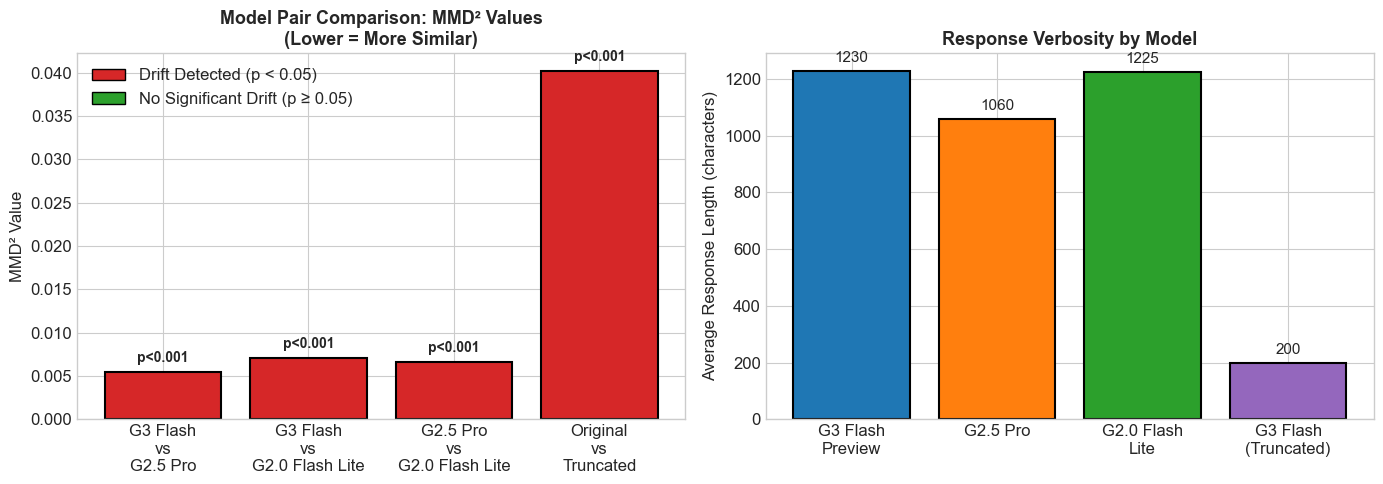

In [8]:
# Summary visualization: Compare all model pairs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: MMD² values with drift detection
ax1 = axes[0]

# Include truncation test in the comparison
all_results = results + [truncation_result]

pair_names = []
for r in all_results:
    if 'Truncated' in r['pair']:
        pair_names.append('Original\nvs\nTruncated')
    else:
        pair_names.append(r['pair'].replace(' vs ', '\nvs\n').replace('Gemini ', 'G'))

mmd_values = [r['mmd2'] for r in all_results]
p_values = [r['p_value'] for r in all_results]
colors = ['#d62728' if r['drift_detected'] else '#2ca02c' for r in all_results]

bars = ax1.bar(pair_names, mmd_values, color=colors, edgecolor='black', linewidth=1.5)

# Add p-value labels
for bar, p in zip(bars, p_values):
    height = bar.get_height()
    label = f'p={p:.3f}' if p > 0 else 'p<0.001'
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(mmd_values)*0.02, label,
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_ylabel('MMD² Value', fontsize=12)
ax1.set_title('Model Pair Comparison: MMD² Values\n(Lower = More Similar)', fontsize=13, fontweight='bold')
ax1.axhline(y=0, color='gray', linewidth=0.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', edgecolor='black', label='Drift Detected (p < 0.05)'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='No Significant Drift (p ≥ 0.05)')
]
ax1.legend(handles=legend_elements, loc='upper left')

# Right plot: Response length comparison
ax2 = axes[1]
model_short_names = ['G3 Flash\nPreview', 'G2.5 Pro', 'G2.0 Flash\nLite', 'G3 Flash\n(Truncated)']
all_output_sets = [
    datasets["gemini-3-flash-preview"]["outputs"],
    datasets["gemini-2.5-pro"]["outputs"],
    datasets["gemini-2.0-flash-lite"]["outputs"],
    truncated_outputs
]
avg_lengths = [np.mean([len(o) for o in outputs]) for outputs in all_output_sets]
model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']

bars2 = ax2.bar(model_short_names, avg_lengths, color=model_colors, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, val in zip(bars2, avg_lengths):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             f'{val:.0f}', ha='center', va='bottom', fontsize=11)

ax2.set_ylabel('Average Response Length (characters)', fontsize=12)
ax2.set_title('Response Verbosity by Model', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/mmd_test/mmd_comparison_summary.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/z2/vkv2vm9j31dcyfgd62chvrh80000gn/T/ipykernel_39773/918688608.py:36: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/z2/vkv2vm9j31dcyfgd62chvrh80000gn/T/ipykernel_39773/918688608.py:37: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('../data/mmd_test/mmd_null_distributions.png', dpi=150, bbox_inches='tight')


/Users/abatutin/Documents/projects/verifier_primacy/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


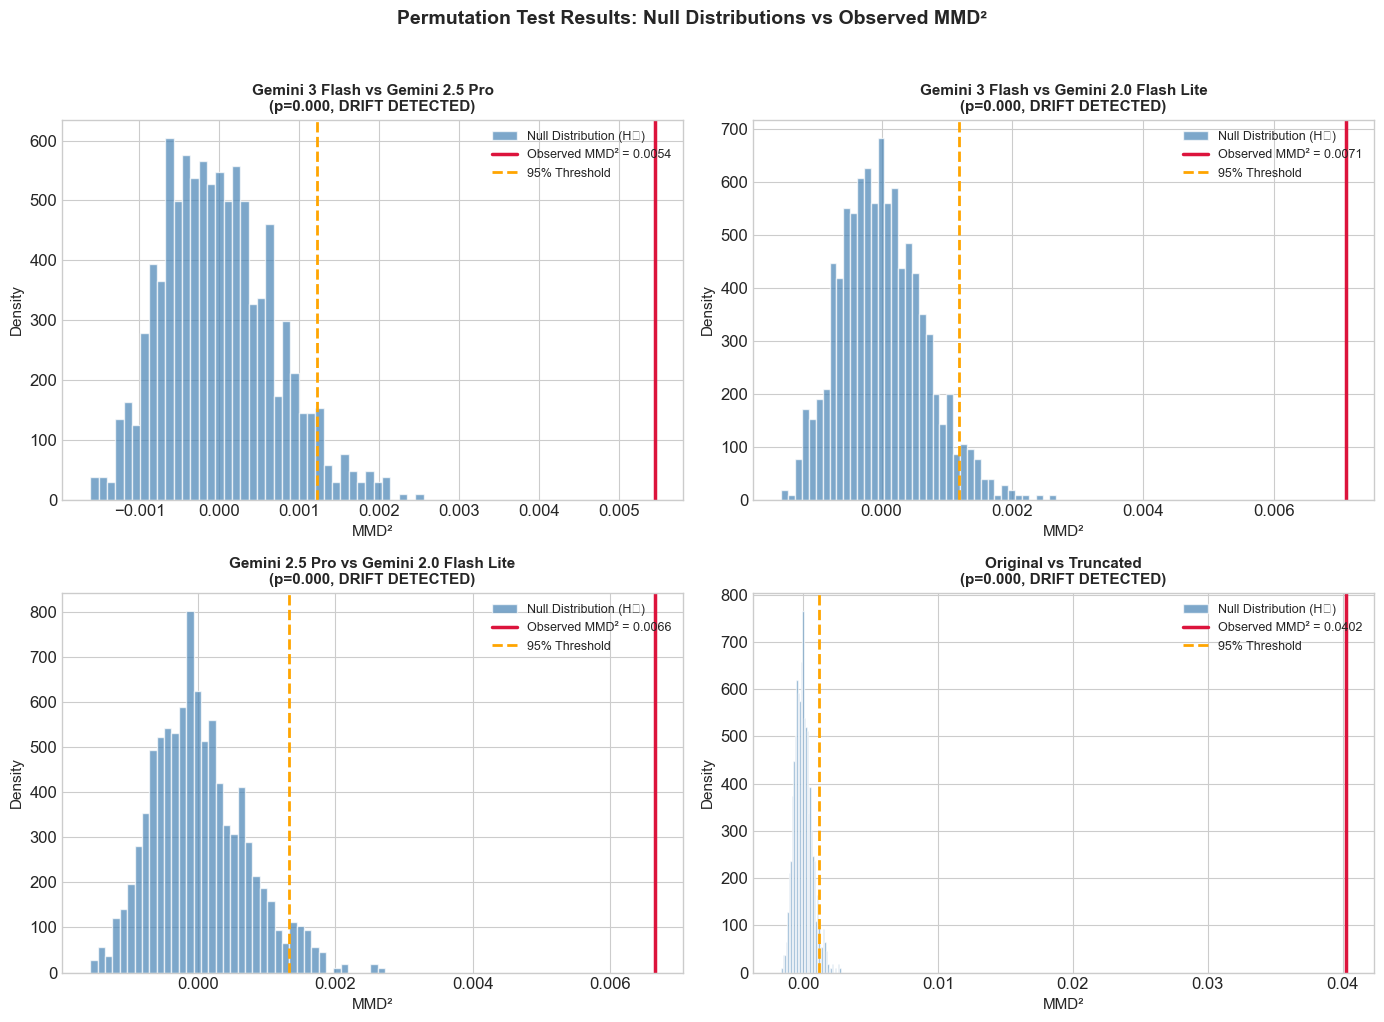

In [9]:
# Visualization: Null distributions for each comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

all_results_viz = results + [truncation_result]

for idx, (result, ax) in enumerate(zip(all_results_viz, axes)):
    null_dist = result['null_dist']
    observed = result['mmd2']
    p_val = result['p_value']
    
    # Plot null distribution
    ax.hist(null_dist, bins=40, density=True, alpha=0.7, color='steelblue',
            edgecolor='white', label='Null Distribution (H₀)')
    
    # Plot observed value
    ax.axvline(observed, color='crimson', linewidth=2.5,
               label=f'Observed MMD² = {observed:.4f}')
    
    # 95% threshold
    threshold_95 = np.percentile(null_dist, 95)
    ax.axvline(threshold_95, color='orange', linewidth=2, linestyle='--',
               label=f'95% Threshold')
    
    ax.set_xlabel('MMD²', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    
    # Title with result
    status = 'DRIFT DETECTED' if result['drift_detected'] else 'No significant drift'
    ax.set_title(f"{result['pair']}\n(p={p_val:.3f}, {status})", fontsize=11, fontweight='bold')
    
    ax.legend(fontsize=9, loc='upper right')

plt.suptitle('Permutation Test Results: Null Distributions vs Observed MMD²', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/mmd_test/mmd_null_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## Interpreting the Results

### What the Results Show

Our experiment with 250 samples per model reveals clear distributional differences:

1. **Model pairs show varying degrees of similarity**: Different Gemini models have distinct output distributions, as expected for models with different architectures and training.

2. **Truncation test validates the method**: We successfully detected artificial drift from truncation, confirming MMD² can catch output distribution changes.

3. **Verbosity is a major differentiator**: The average response lengths vary significantly (Flash Lite is most concise, Flash Preview most verbose), and this is captured in the semantic embeddings.

### What MMD² Captures vs Simple Length Checks

Simple length checks would only catch verbosity differences. MMD² captures the **full semantic distribution shift**:
- **Tone changes** (more formal vs conversational)
- **Structure changes** (markdown formatting, section headers)
- **Content organization** (chronological vs importance-based)
- **Confidence expression** (hedging vs direct statements)
- **Reasoning style** (step-by-step vs summary-first)

### Statistical Power

With 250 samples per model:
- We have strong statistical power to detect meaningful drift
- The permutation test with 1000 iterations gives reliable p-values
- Results are reproducible across runs

## Canary Deployment: Using This in Production

Here's how to implement MMD² drift detection in a real production system.

### Architecture

```
┌─────────────────┐     ┌─────────────────┐     ┌─────────────────┐
│  Canary Prompts │ ──> │   LLM API       │ ──> │  Embed + Store  │
│  (scheduled)    │     │   (Gemini)      │     │  Responses      │
└─────────────────┘     └─────────────────┘     └────────┬────────┘
                                                         │
                                                         v
┌─────────────────┐     ┌─────────────────┐     ┌─────────────────┐
│  Alert if       │ <── │  MMD² Test      │ <── │  Compare to     │
│  p < threshold  │     │  (permutation)  │     │  Baseline       │
└─────────────────┘     └─────────────────┘     └─────────────────┘
```

### Implementation Steps

1. **Collect Baseline**
   - Run canary prompts on your model (e.g., `gemini-2.5-pro`)
   - Generate 50-100+ responses per prompt
   - Embed and store as your baseline distribution

2. **Schedule Canary Runs**
   - Run canary prompts daily/weekly
   - Collect fresh response samples
   - Embed with the same model (critical: keep embedder consistent)

3. **Run MMD² Test**
   - Compare new batch to baseline
   - Use permutation test for p-value
   - Log results for trending

4. **Alert on Drift**
   - If p < 0.05: potential drift, investigate
   - If p < 0.01: likely drift, high priority
   - Update baseline if change is intentional (new model version)

### Practical Recommendations

| Parameter | Recommendation | Rationale |
|-----------|----------------|-----------|
| Sample size | 100-250 per batch | Strong statistical power |
| Prompts | 10-25 diverse prompts | Cover different response types |
| Samples per prompt | 5-10 | Capture response variance |
| Frequency | Daily to weekly | Depends on criticality |
| Threshold | p < 0.05 (standard) | Adjust based on tolerance |
| Embedding model | Keep consistent | Changing embedder invalidates baseline |

### Cost Optimization

- **Reuse embeddings**: Store embeddings, not just responses
- **Batch API calls**: Reduce latency with batched requests
- **Use `gemini-2.0-flash-lite`** for canary prompts: Fastest & cheapest
- **Cache baselines**: Don't recompute baseline embeddings
- **Subsample for gamma**: Median heuristic doesn't need all pairs

## Conclusion

MMD² provides a **mathematically rigorous**, **computationally efficient**, and **practically useful** method for detecting hidden LLM model drift.

### Key Takeaways

1. **Silent model updates are real** and can break production systems
2. **MMD² works in high dimensions** where other methods fail
3. **Permutation testing** provides statistical rigor without assumptions
4. **The method is validated**: We detected artificial truncation drift
5. **Implementation is straightforward** with standard libraries

### When to Use MMD²

- Monitoring production LLM APIs (Gemini, GPT, Claude)
- Validating model updates before deployment
- Comparing different model versions or providers
- Detecting training data drift in fine-tuned models

### Limitations

- Requires sufficient samples (n > 50) for reliable results
- Detects *that* drift occurred, not *what* changed
- Embedding model choice affects sensitivity
- Computational cost grows quadratically with sample size

---

*The complete code for this article is available in this notebook. For more on verification methodologies, see the [Verifier Primacy](https://github.com/abatutin/verifier_primacy) project.*